In [1]:
#Importing the necessary scripts
from Scripts.ProcessingEmbeddings import *
from Scripts.HardDebias import *
from Scripts.utils import *

#Importing the necessary packages
import numpy as np


In [3]:
#Create an embeddings object with the embeddings file
glove=Embeddings('Data/glove-wiki-gigaword-300.txt', gensim=False)

Loading Data/glove-wiki-gigaword-300.txt embeddings
vectors shape: (400000, 300), word2idx length: 400000, vocab length: 400000


In [4]:
# From the embeddings object, get the vectors, the word2idx dictionary, the vocab list, and the dict_vectors dictionary
# Because the gensim embeddings carry no information on the file, we need to use the built-in function from gensim to get the vocab in descending frequency.
glove.model.sort_by_descending_frequency()
vectors=glove.vectors
word2idx=glove.word2idx
vocab=glove.words
dict_vectors = glove.get_word_vector_dict()

#print the first 20 words in the vocab
print(vocab[:20])

#Print the shape of the vectors
print("vectors shape", vectors.shape)

#Print a boolean to check if there are any NaNs in the vectors
print("Missing values in vectors?", np.isnan(vectors).any())

['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s", 'for', '-', 'that', 'on', 'is', 'was', 'said', 'with', 'he', 'as']
vectors shape (400000, 300)
Missing values in vectors? False


In [5]:
# Getting a limited vocabulary to debias the embeddings.
vocab_nopunct, vectors_nopunct, word2idx_nopunct, dict_vec_nopunct = glove.limit_vocab(vectors, word2idx, vocab)

100%|██████████| 400000/400000 [00:00<00:00, 639883.57it/s]


Size of limited vocabulary: 327185


## Hard-Debias Algorithm

#### Preliminaries

In [6]:
# Cleaning the vocabulary from pounctuation and numbers
vocab_cleaned, vectors_cleaned, word2idx_cleaned, dict_vec_cleaned = glove.limit_vocab(
    vectors, word2idx, vocab)


100%|██████████| 400000/400000 [00:00<00:00, 637047.13it/s]


Size of limited vocabulary: 327185


In [7]:
#Getting the definitional sets to calculate afterwards the gender direction. The first 10 gender sets were proposed by Bolukbasi et al. (2016)
#Definitional sets for race where proposed by Manzini et al. in Multiclass debiasing of embeddings: https://github.com/TManzini/DebiasMulticlassWordEmbedding/blob/master/Debiasing/data/vocab/race_attributes_optm.json

def_sets = {
    "gender": [
        ['she', 'he'], ['herself', 'himself'], 
        ['her', 'his'], ['daughter', 'son'], ['girl', 'boy'],
        ['mother', 'father'], ['woman', 'man'], ['mary', 'john'],
        ['gal', 'guy'], ['female', 'male'], ['aunt', 'uncle']],

    "race": [
        ["black", "caucasian", "asian", "hispanic"],
      		["african", "caucasian", "asian", "hispanic"],
      		["black", "white", "asian", "latino"],
      		["africa", "europe", "asia", "mexico"],
      		["africa", "america", "china", "latin-america"],
    ]
}

#Equalizing pairs for gender debiasing were first published by Bolukbasi et al. in https://github.com/tolga-b/debiaswe/blob/master/data/equalize_pairs.json
# Equalizing sets for race where defined by Manzini as equal to the defining set (Manzini et al., 2019.p.3)
equalizing_lists = {
    "gender": [
        ["monastery", "convent"], ["spokesman", "spokeswoman"], 
        ["Catholic_priest", "nun"], ["Dad", "Mom"], ["Men", "Women"],
        ["councilman", "councilwoman"], ["grandpa", "grandma"], 
        ["grandsons", "granddaughters"], ["prostate_cancer", "ovarian_cancer"],
        ["testosterone", "estrogen"], ["uncle", "aunt"], 
        ["wives", "husbands"], ["Father", "Mother"], ["Grandpa", "Grandma"],
        ["He", "She"], ["boy", "girl"], ["boys", "girls"], ["brother", "sister"], 
        ["brothers", "sisters"], ["businessman", "businesswoman"],
        ["chairman", "chairwoman"], ["colt", "filly"], ["congressman","congresswoman"], 
        ["dad", "mom"], ["dads", "moms"], ["dudes", "gals"],
        ["ex_girlfriend", "ex_boyfriend"], ["father", "mother"],
        ["fatherhood", "motherhood"], ["fathers", "mothers"], ["fella", "granny"],
        ["fraternity", "sorority"], ["gelding", "mare"], ["gentleman", "lady"], 
        ["gentlemen", "ladies"], ["grandfather", "grandmother"],
        ["grandson", "granddaughter"], ["he", "she"], ["himself", "herself"], 
        ["his", "her"], ["king", "queen"], ["kings", "queens"],
        ["male", "female"], ["males", "females"], ["man", "woman"],
        ["men", "women"], ["nephew", "niece"], ["prince", "princess"],
        ["schoolboy", "schoolgirl"], ["son", "daughter"], ["sons", "daughters"], 
        ["twin_brother", "twin_sister"]]}

#Words taken from Wang et al. to enrich the equalizing pairs
female_vocab = ['countrywoman',  'witches',  'maidservant',  'mothers',  'diva',  'actress',  'spinster',  'mama',  'duchesses',  'countrywomen',  'hostesses',  'suitors',  'menopause',  'clitoris',  'princess',  'governesses',  'abbess',  'women',  'widow',  'ladies',  'sorceresses',  'madam',  'brides',  'baroness',  'niece',  'widows',  'lady',  'sister',  'brides',  'nun',  'obstetrics',  'her',  'marchioness',  'princesses',  'empresses',  'mare',  'chairwoman',  'convent',  'priestesses',  'girlhood',  'ladies',  'queen',  'gals',  'mommies',  'maid',  'spokeswoman',  'seamstress',  'cowgirls',  'chick',  'spinsters',  'empress',  'mommy',  'gals',  'enchantress',  'gal',  'motherhood',  'estrogen',  'godmother',  'strongwoman',  'goddess',  'matriarch',  'aunt',  'chairwomen',  'maam',
                'sisterhood',  'hostess',  'estradiol',  'wife',  'mom',  'stewardess',  'females',  'spokeswomen',  'ma',  'belle',  'minx',  'maiden',  'witch',  'miss',  'nieces',  'mothered',  'cow',  'belles',  'granddaughter',  'fiancees',  'stepmothers',  'grandmothers',  'schoolgirl',  'hen',  'granddaughters',  'bachelorette',  'camerawoman',  'moms',  'her',  'mistress',  'lass',  'policewoman',  'nun',  'actresses',  'saleswomen',  'girlfriend',  'councilwoman',  'lady',  'stateswoman',  'maternal',  'lass',  'landlady',  'ladies',  'wenches',  'sorority',  'duchess',  'ballerina',  'chicks',  'fiancee',  'fillies',  'wives',  'she',  'businesswoman',  'masseuses',  'heroine',  'doe',  'girlfriends',  'queens',  'sisters',  'stepmother',  'daughter',  'cowgirl',  'daughters',  'soprano',
                'saleswoman',  'mistress',  'nuns',  'headmistresses',  'lasses',  'congresswoman',  'housewife',  'priestess',  'abbesses',  'toque',  'sororities',  'stewardesses',  'filly',  'czarina',  'stepdaughters',  'herself',  'girls',  'lionesses',  'lady',  'vagina',  'hers',  'masseuse',  'cows',  'aunts',  'wench',  'toques',  'wife',  'lioness',  'sorceress',  'mother',  'lesbians',  'female',  'waitresses',  'ovum',  'ovary',  'stepdaughter',  'businesswomen',  'heiress',  'waitress',  'headmistress',  'woman',  'governess',  'bride',  'grandma',  'bride',  'gal',  'lesbian',  'ladies',  'girl',  'grandmother',  'mare',  'hens',  'nuns',  'maidservants',  'heroines']
male_vocab = ['countryman',  'wizards',  'manservant',  'fathers',  'divo',  'actor',  'bachelor',  'papa',  'dukes',  'countrymen',  'hosts',  'airmen',  'andropause',  'penis',  'prince',  'governors',  'abbot',  'men',  'widower',  'gentlemen',  'sorcerers',  'sir',  'bridegrooms',  'baron',  'nephew',  'widowers',  'lord',  'brother',  'grooms',  'priest',  'andrology',  'his',  'marquis',  'princes',  'emperors',  'stallion',  'chairman',  'monastery',  'priests',  'boyhood',  'fellas',  'king',  'dudes',  'daddies',  'manservant',  'spokesman',  'tailor',  'cowboys',  'dude',  'bachelors',  'emperor',  'daddy',  'guys',  'enchanter',  'guy',  'fatherhood', 
                'androgen',  'godfather',  'strongman',  'god',  'patriarch',  'uncle',  'chairmen',  'sir',  'brotherhood',  'host',  'testosterone',  'husband',  'dad',  'steward',  'males',  'spokesmen',  'pa',  'beau',  'stud',  'bachelor',  'wizard',  'sir',  'nephews',  'fathered',  'bull',  'beaus',  'grandson',  'fiances',  'stepfathers',  'grandfathers',  'schoolboy',  'rooster',  'grandsons',  'bachelor',  'cameraman',  'dads',  'him',  'master',  'lad',  'policeman',  'monk',  'actors',  'salesmen',  'boyfriend',  'councilman',  'fella',  'statesman',  'paternal',  'chap',  'landlord',  'lords',  'blokes',  'fraternity',  'duke',  'dancer',  'dudes',  'fiance',
                'colts',  'husbands',  'he',  'businessman',  'masseurs',  'hero',  'deer',  'boyfriends',  'kings',  'brothers',  'stepfather',  'son',  'cowboy',  'sons',  'baritone',  'salesman',  'paramour',  'monks',  'headmasters',  'lads',  'congressman',  'househusband',  'priest',  'abbots',  'beard',  'fraternities',  'stewards',  'colt',  'czar',  'stepsons',  'himself',  'boys',  'lions',  'gentleman',  'penis',  'his',  'masseur',  'bulls',  'uncles',  'bloke',  'beards',  'hubby',  'lion',  'sorcerer',  'father',  'gays',  'male',  'waiters',  'sperm',  'prostate',  'stepson',  'businessmen',  'heir',  'waiter',  'headmaster',  'man',  'governor',  'bridegroom', 
                'grandpa',  'groom',  'dude',  'gay',  'gents',  'boy',  'grandfather',  'gelding',  'roosters',  'priests',  'busboy',  'heros']

#added the gendered pairs to the equalizing list (equalizing_lists['gender'] if the pairs are not there already
gendered_pairs = list(zip(male_vocab, female_vocab))
list_pairs = [tuple for tuple in gendered_pairs if tuple not in equalizing_lists['gender']]
equalizing_lists['gender'] = equalizing_lists['gender']+list_pairs

#Some of the words were taken from the analogies' templates from Cheng and Manzini.
#The list is not the same, however, because some of the words were not neutral, but carried some
#relation to the social categories.
neutral_words = ["manager", "executive", "doctor", "lawyer", "programmer",
                 "scientist", "soldier", "supervisor", "rancher", "janitor",
                 "firefighter", "officer", "secretary", "nurse", "clerk", "artist",
                 "homemaker", "dancer", "singer", "librarian", "maid", "hairdresser", "stylist",
                 "receptionist", "counselor", "leader", "farmer",
                 "engineer", "laborer", "teacher",
                 "slave", "musician", "runner", "criminal", "homeless",
                 "greedy", "cheap", "hairy", "liberal",
                 "judgemental", "conservative", "familial",
                 "violent", "terrorist", "dirty", "uneducated", "educated"]


#However, also the vocabulary without the gendered words from the list can be conceived as neutral, according to Bolukbasi et al.


#### Gender Debiasing

In [8]:
#putting the def_sets on the right format for debiasing
def_set_gender=utils.prepare_def_sets_subspace(def_sets["gender"])


In [9]:
deb_vect_gender, deb_vocab_gender, deb_word2idx_gender,deb_dict_gender = hard_debias(vectors,
                             dict_vectors, 
                             word2idx_cleaned,
                             vocab_cleaned, 
                             equalizing_lists['gender'], 
                             def_set_gender,
                             1,
                             normalize_dir=False,
                             normalize=None,
                             centralizing=True)

Length of vectors set: 22
Running PCA with 1 components


## Evaluation

In [10]:
from Scripts.Visualization import *
from Scripts.Evaluation import *
import pandas as pd

### Gender Bias Pre-Post

In [11]:
# To compute the simple gender bias, we need to get the embeddings of "he" and "she"
he_embed = dict_vectors['he']
she_embed = dict_vectors['she']

# Using the gender bias function to compute the bias of all the words in the limited dataset
#We create a dictionary with the word as key and the bias as value
simple_gender_bias_original = compute_gender_simple_bias(dict_vec_cleaned, he_embed, she_embed)

#And a dictionary of the debiased scores
gender_bias_after_debiasing=compute_gender_simple_bias(deb_dict_gender, he_embed, she_embed)

In [12]:
#To compute the direct gender bias, we need to compute the direct bias per word. 
gender_direction = identify_bias_subspace(
    dict_vectors, def_set_gender, 1, centralizing=True)

#Dictionary with direct bias
direct_gender_bias_original = compute_direct_bias(
    dict_vec_cleaned, vocab_cleaned, gender_direction)

#Dictionary with direct bias after debiasing
direct_gender_bias_debiased = compute_direct_bias(
    deb_dict_gender, neutral_words, gender_direction)


Length of vectors set: 22
Running PCA with 1 components


In [13]:
#Testing the scores in the occupations lists
occupations = ['assistant','secretary','data scientist', 'scientist', 'politician','janitor', 'hairdresser','teacher', 'bartender','midwife','doctor','ballerina','dancer','pediatrician','surgeon', 'physician', 'shopkeeper',  'nurse', 'interior designer', 'architect', 'maid', 'housekeeper', 'soprano', 'baritone', 'servant',  'vocalists', 'guitarists','carpenter','clerk','manager','supervisor','driver','software developer','lawyer','pitcher', 'bookkeeper', 'infielder', 'receptionist', 'investigator', 'pundit', 'chancellor', 'maestro','lecturer','salesperson','homemaker', 'receptionist','librarian', 'nanny', 'bookkeeper', 'stylist','housekeeper','guidance counselor','skipper', 'protege','philosopher','captain', 'architect', 'financier', 'warrior', 'broadcaster', 'magician', 'figher','pilot', 'boss']
bias_df=get_bias_score_df_from_list(simple_gender_bias_original,gender_bias_after_debiasing, occupations,vocab_cleaned,deb_vocab_gender)
plot_bias_bar(bias_df, "Gender bias on occupations (original vs debiased)", "Occupations")

precision 1.0
precision 0.313


(0.313, <AxesSubplot:title={'center':'Debiased_GloVe'}>)

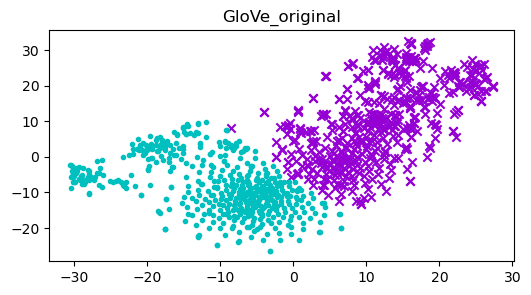

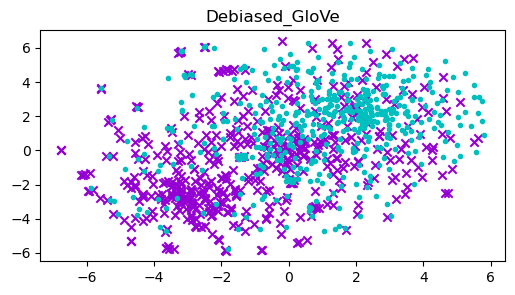

In [14]:
#Also, to test, whether the algorithm is working correctly, we can check the clusters of biased words:
# at first the clusters should be linearly separable, and after debiasing, they should be mixed
c_w2i, c_vocab, female_words, male_words, y_true=getting_biased_words(simple_gender_bias_original, def_sets['gender'], 500, word2idx)

#Clustering with k-means to visualize clusters in original embeddings
gendered_vectors=utils.extract_vectors(male_words + female_words, vectors_cleaned, word2idx_cleaned)
cluster_and_visualize(male_words + female_words,
                      np.array(gendered_vectors), 'GloVe_original', y_true, random_state=42)

#Clustering with k-means to visualize clusters in debiased embeddings
gendered_debiased_vectors = utils.extract_vectors(
    male_words + female_words, deb_vect_gender, deb_word2idx_gender)

cluster_and_visualize(male_words + female_words, np.array(gendered_debiased_vectors),
                      'Debiased_GloVe', y_true, random_state=42)


###  Random Words: bias scores and neighbors

In [15]:
from collections import defaultdict
#set a seed for reproducibility
np.random.seed(42)
#choosing random words from the vocabulary
random_words = np.random.choice(vocab_cleaned[:10000], size=50)

#setting parameters for the gensim method "most_similar"
topn = 3


In [16]:
random_words

array(['clouds', 'italy', 'anymore', 'cardinals', 'honest', 'eventual',
       'community', 'staying', 'sadr', 'vertical', 'henry', 'love',
       'rubin', 'drawn', 'monument', 'breast', 'jeffrey', 'pass',
       'rushed', 'maryland', 'withdrawn', 'parole', 'listened', 'rugby',
       'garbage', 'fears', 'neighboring', 'personalities', 'deceased',
       'political', 'concluded', 'operate', 'reflected', 'controlled',
       'symbols', 'session', 'female', 'revolutionary', 'consensus',
       'roc', 'albania', 'carpet', 'evaluate', 'destinations', 'colombia',
       'physicians', 'lobbyists', 'travels', 'laura', 'loyalty'],
      dtype='<U18')

In [17]:
#Getting the gender bias score for the random words list
bias_df = get_bias_score_df_from_list(
    simple_gender_bias_original, gender_bias_after_debiasing, random_words, vocab_cleaned, deb_vocab_gender)
plot_bias_bar(
    bias_df, "Gender bias on random_words (original vs debiased)", "Random_words")


In [18]:
#First let's get the 50 nearest neighbors of the random words in the original embeddings
k_neigh= get_k_nearest_neighbors(random_words, dict_vec_cleaned, vocab_cleaned, vectors_cleaned,
                                 word2idx_cleaned, k=50)
#let's put them on a list
list_neigh = get_list_neighbors(k_neigh)

100%|██████████| 50/50 [01:19<00:00,  1.60s/it]


In [19]:
from Scripts.Evaluation import get_frequency_original_neighbors

#We find the frequency of the original neighbors in the debiased embeddings
neig_freq2=get_frequency_original_neighbors(
    random_words, k_neigh, deb_dict_gender, deb_vocab_gender, deb_vect_gender, deb_word2idx_gender, neighbours_num=50)

df_freq = pd.DataFrame(neig_freq2, columns=['word', 'previous_neighbours', 'freq'])


50it [01:20,  1.62s/it]


In [20]:
from Scripts.Visualization import plot_frequency_original_neighbors
#Let's get a plot of the results
plot_frequency_original_neighbors(df_freq, "Frequency of original neighbors in debiased embeddings", 'Original neighbors')


In [21]:
#k_neigh_debiased= get_k_nearest_neighbors(random_words, deb_dict_gender, deb_vocab_gender, deb_vect_gender, deb_word2idx_gender, k=50)

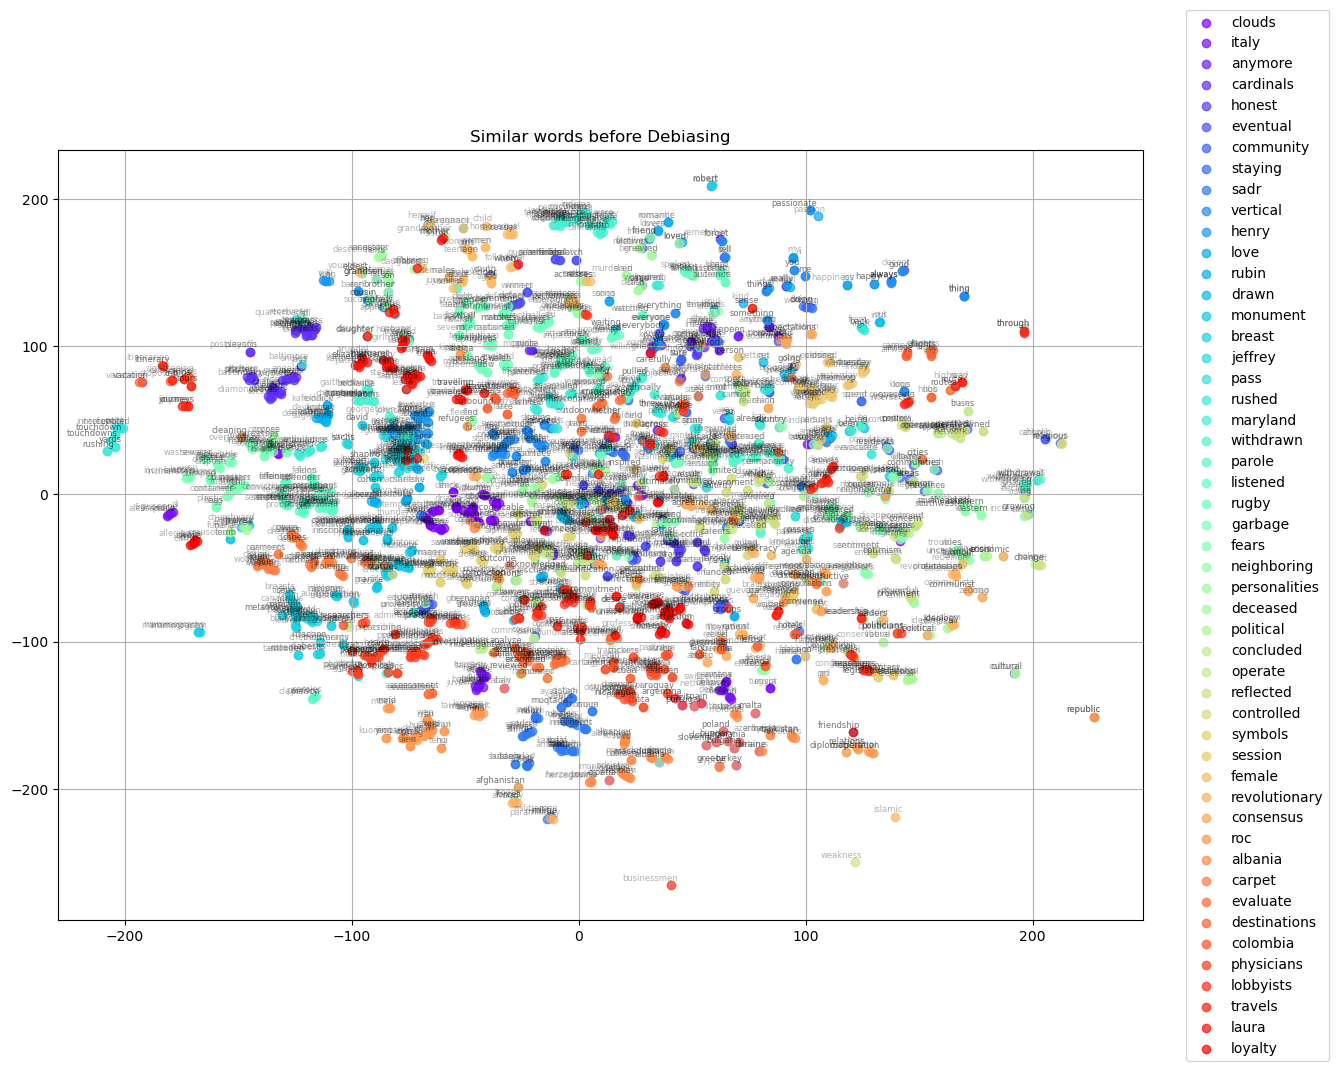

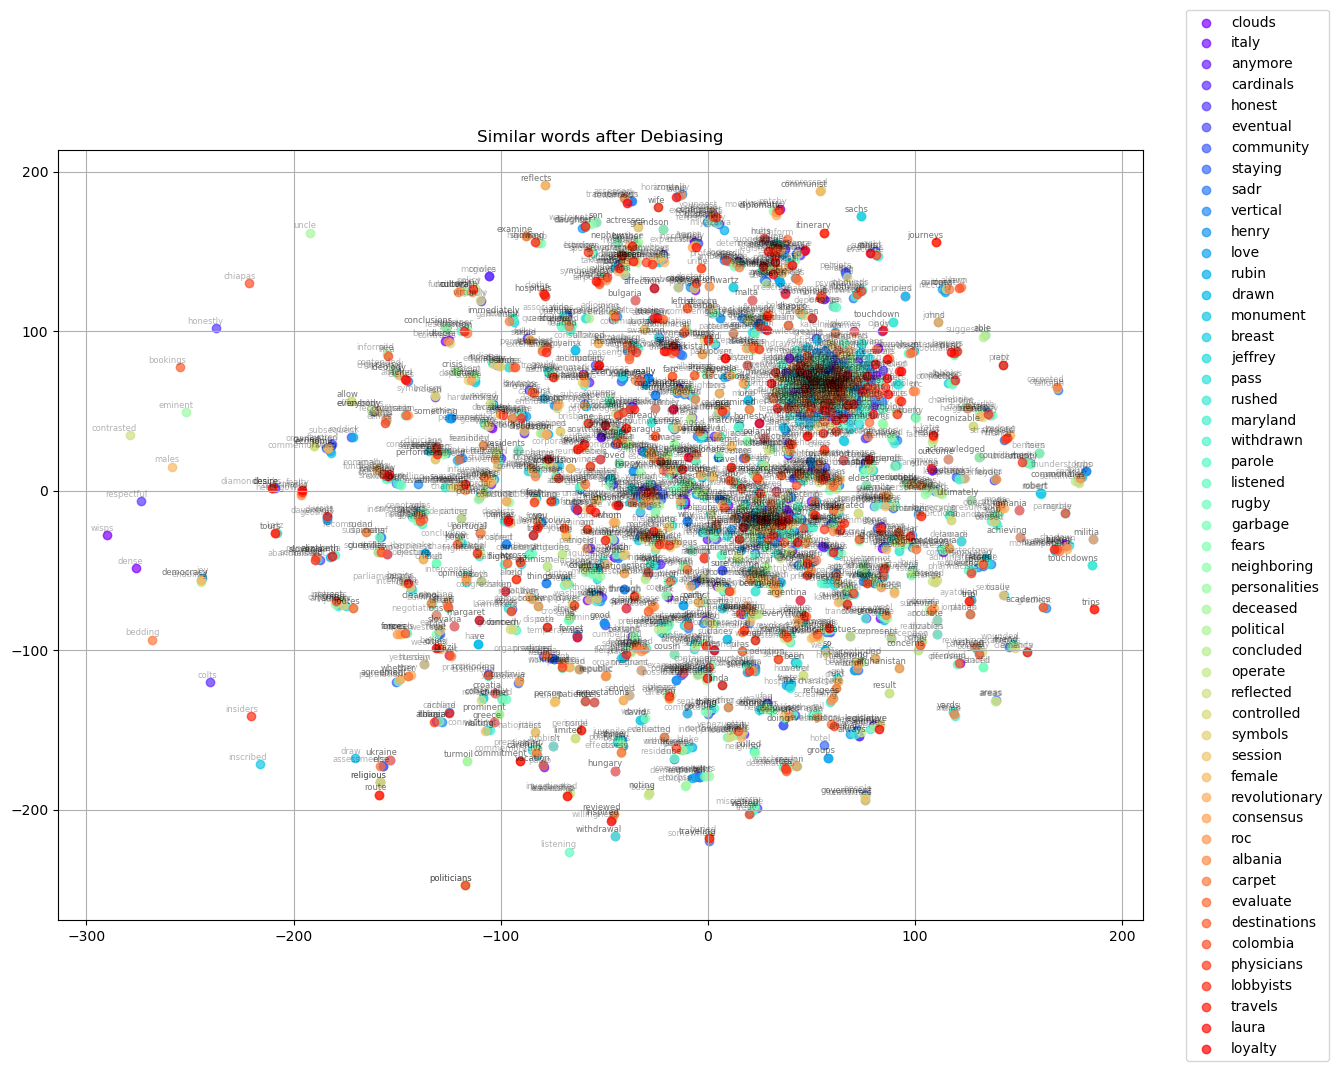

In [22]:
from sklearn.manifold import TSNE
import numpy as np
from Scripts.Visualization import tsne_plot_similar_words
from Scripts.Evaluation import get_vectors_for_tsne

#This approach was inspired by the following blog post:https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d

#Getting the Gensim models to plot the neighbors
gender_debiased = create_KeyedVectors(deb_vect_gender, deb_vocab_gender, 300)
model_original = create_KeyedVectors(vectors_cleaned, vocab_cleaned, 300)

keys = random_words
embeddings_en_2d, db_embeddings_en_2d, word_clusters = get_vectors_for_tsne(
    keys, model_original, gender_debiased, k=50)

tsne_plot_similar_words('Similar words before Debiasing',
                        keys, embeddings_en_2d, word_clusters, 0.7, "Figures/Random_words_neighbors_before_debiasing.png")
tsne_plot_similar_words('Similar words after Debiasing',
                        keys, db_embeddings_en_2d, word_clusters, 0.7, "Figures/Random_words_neighbors_after_debiasing.png")


In [29]:
distances_original, distances_debiased = get_distance_to_neighbors(k_neigh,
                                                                   dict_vec_cleaned, deb_dict_gender)

df_neigh_distances=get_df_distances(distances_original,distances_debiased)

#use df_neigh_distances to get the average distance original and distance debiased for each word using pandas
df_average=df_neigh_distances[['word', 'distance_original', 'distance_debiased']].groupby('word').mean()

#now add a column of the difference between the two mean distances
df_average['difference']=abs(df_average['distance_original']-df_average['distance_debiased'])
df_average=df_average.sort_values(by='difference', ascending=True)

df_average=df_average.reset_index()


In [30]:
#from Scripts.Visualization import plot_average_distance
plot_average_distance(
    df_average, 'Average cosine distance to neighbors before and after debiasing', 'Words Chosen at Random'
)


### Distribution of neighbors test

In [62]:
#get a list with the first value of each tuple in the neighbors list
neighbors_words = []
for random_word in k_neigh:
    for i in range(len(k_neigh[random_word])):
        neighbors_words.append(k_neigh[random_word][i][0])


In [63]:
from Scripts.Evaluation import p_value_perm_neighs

p_value_perm_neighs(random_words, neighbors_words, dict_vec_cleaned,
                    deb_dict_gender)

original mean: 0.012666596077075445
num of samples 250000


100%|██████████| 250000/250000 [1:51:06<00:00, 37.50it/s]  


0.49834

But when running it w¡th another sample of random words, then the P-value was different:

In [70]:
#On a previous attempt, for the following random words, I got a p-value of 0.29

random_words=['athen', 'zindel', 'wyattville', 'fmqb', 'zinfandel', 'nektar',
     'mantovani', 'oper', 'corio', 'pavletic', 'kittanning', 'summeren',
       'monsey', 'chink', 'aurunci', 'robbia', 'frisky', 'meekness',
      'wipo', 'mbomo', 'breakpoints', 'jaegerstaetter', 'wor', 'jetpack',
      'kucharczyk', 'mythago', 'boonton', 'ywain', 'eraiba', 'obiko',
       'bongiovanni', 'zalman', 'stowarzyszenie', 'prophets', 'katju',
       'family', 'tests', 'longmei', 'espagnol', 'tanney', 'luiza',
       'rasin', 'hassim', 'nava', 'warlick', 'monda', 'grimme', 'ansatz',
       'puteaux', 'joanette']

neighbors = get_k_nearest_neighbors(random_words,
                                    dict_vec_cleaned, vocab_cleaned,
                                    vectors_cleaned, word2idx_cleaned, k=50)


array(['athen', 'zindel', 'wyattville', 'fmqb', 'zinfandel', 'nektar',
       'mantovani', 'oper', 'corio', 'pavletic', 'kittanning', 'summeren',
       'monsey', 'chink', 'aurunci', 'robbia', 'frisky', 'meekness',
       'wipo', 'mbomo', 'breakpoints', 'jaegerstaetter', 'wor', 'jetpack',
       'kucharczyk', 'mythago', 'boonton', 'ywain', 'eraiba', 'obiko',
       'bongiovanni', 'zalman', 'stowarzyszenie', 'prophets', 'katju',
       'family', 'tests', 'longmei', 'espagnol', 'tanney', 'luiza',
       'rasin', 'hassim', 'nava', 'warlick', 'monda', 'grimme', 'ansatz',
       'puteaux', 'joanette'], dtype='<U19')

In [282]:
p_value_perm_neighs(random_words, neighbors_words, dict_vec_cleaned,
                    deb_dict_gender)


original mean: -0.01699070871639722
num of samples 250000


100%|██████████| 250000/250000 [17:00<00:00, 245.04it/s]


0.029432

### Distribution of distances test

In [29]:
from Scripts.Evaluation import get_df_random_words_neighbor_analysis_values


df_merged=get_df_random_words_neighbor_analysis_values(
    vocab_cleaned,vocab_cleaned, dict_vec_cleaned, vectors_cleaned, word2idx_cleaned, deb_dict_gender, deb_vocab_gender, deb_vect_gender, deb_word2idx_gender, k=50, num_iterations=50, size_random_set=50)


  0%|          | 0/50 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [12]:
df_merged.to_csv("Data/df_merged_50x50neigh.csv", index=False)

In [13]:
#get the mean values from the dataframe
df_mean=df_merged[['freq','distance_original', 'distance_debiased', 'iteration']].groupby('iteration').agg('mean').reset_index()

#create a long format table of df_mean
df_mean_long=pd.melt(df_mean, id_vars=['iteration'], value_vars=['distance_original', 'distance_debiased', 'freq'])

In [37]:
#plot boxplots for distance original and distance debiased
import plotly.express as px
fig = px.box(df_mean_long[df_mean_long['variable'].str.contains('distance')], x="variable", y="value", points="all",
                title="Average cosine distance to neighbors before and after debiasing",
                labels={"variable": "Cosine Distance", "value": "Average Cosine Distance to Neighbors",
                        'distance_original':"Original Embeddings", 'distance_debiased':"Debiased Embeddings"},
                color_discrete_sequence = ['#636EFA'],
                template='plotly_white', 
                orientation='v',
                height=800, width=600)
#change y-axis range
fig.update_yaxes(range=[0.5, 0.95])
#save the figure
#fig.write_image("Figures/boxplot_distance_original_debiased_50x20neigh.png", engine='kaleido')

fig.show()

In [24]:
#plot boxplots for distance original and distance debiased
import plotly.express as px
fig = px.box(df_mean_long[df_mean_long['variable'].str.contains(
    'freq')], x="variable", y="value", points="all",
    title="Distribution of original neighbors on 50-vicinity after debiasing",
    labels={"variable": "original neighbors", "value": "Frequency"}, 
    template='plotly_white')
#update y-range
fig.update_yaxes(range=[0, 0.1])
fig.show()


In [46]:
#group by iteration to get mean values of all the columns except for the word
mean_df=df_merged.groupby('iteration').mean()

mean_df['diff_distance'] = mean_df['distance_debiased']-mean_df['distance_original']


/var/folders/bh/g_8v28y122j2fc_vq7b3x8cr0000gn/T/ipykernel_72847/628879099.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [184]:
#use plotly to get a histogram of the difference values
import plotly.express as px
fig = px.histogram(mean_df, x="diff_distance", nbins=8,
                     title="Distribution of the difference between the average cosine distance to neighbors before and after debiasing",
                        labels={"diff_distance": "Difference between the average cosine distance to neighbors before and after debiasing"},
                        template='ggplot2'
                        
                        )
#add vertical line for the zero
fig.add_vline(x=0, line_width=3, line_dash="dash", line_color="red")
#update x-axis range
fig.update_xaxes(range=[0.25, 0.35])
#get the borders of the bins


fig.show()


NameError: name 'mean_df' is not defined

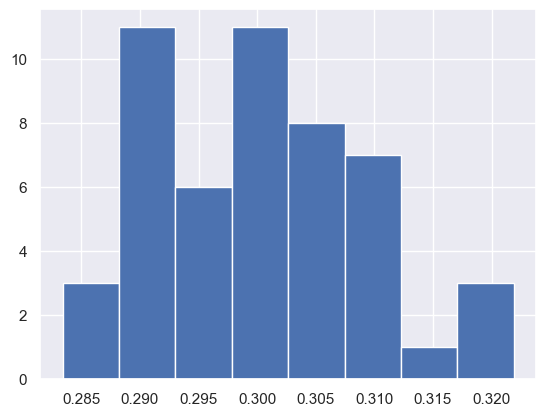

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

#get the the distribution of the values
sns.set()
plt.hist(mean_df['diff_distance'], bins=8)
plt.show()


In [53]:
#get quantiles of the mean_df['diff_distance']
q1,_,q3=mean_df['diff_distance'].quantile([0.25,0.5,0.75])
print(q1,q3)

0.2920119708509775 0.3048202917787517


### Punctuation test


In [31]:
# Getting a limited vocabulary to debias the embeddings.
vocab_punct, vectors_punct, word2idx_punct, dict_vec_punct = glove.limit_vocab(vectors, word2idx, vocab, exclude=vocab_cleaned, exclude_punct=False)
print('Shape of the vectors of words with punctuation marks or numbers:', vectors_punct.shape)
print(type(vectors_punct))


Size of limited vocabulary: 72815
Shape of the vectors of words with punctuation marks or numbers: (72815, 300)
<class 'numpy.ndarray'>


In [32]:
#add the vectors_punct to the deb_vect_gender
all_vectors = np.vstack([deb_vect_gender, vectors_punct])
all_words = deb_vocab_gender+vocab_punct
#paste the two dictionaries together
w2i_all = {w: i for i, w in enumerate(all_words)}
dict_all=get_debiased_dict(all_vectors, w2i_all)



In [33]:
df_punct = get_df_random_words_neighbor_analysis_values(
    vocab_punct[:10000], vocab, dict_vectors, vectors, word2idx,
    dict_all, all_words, all_vectors, w2i_all,
    k=50, num_iterations=1, size_random_set=50)


100%|██████████| 50/50 [01:59<00:00,  2.40s/it]
50it [01:39,  1.99s/it]


In [34]:
df_punct


word  previous_neighbours  freq  distance_original  \
0              1,118                   24  0.48           0.408267   
1               7.90                   25  0.50           0.291948   
2            6-of-10                   25  0.50           0.351270   
3               0-12                   25  0.50           0.490020   
4            9-of-16                   31  0.62           0.331828   
5             129.32                   43  0.86           0.350784   
6         6,000-year                   36  0.72           0.473114   
7         candle-lit                   24  0.48           0.600727   
8      surface-mount                   12  0.24           0.588013   
9        lake-effect                    6  0.12           0.635768   
10       5.6-percent                   33  0.66           0.507433   
11            110-98                   35  0.70           0.458056   
12   through-running                   12  0.24           0.564563   
13              .534                   26  0.52           0.449639   
14      potassium-40                   18  0.36           0.549857   
15             40-32                   29  0.58           0.519660   
16              m3a1                   29  0.58           0.554014   
17              ,390                   37  0.74           0.437166   
18          180-foot                   28  0.56           0.561359   
19       1/4teaspoon                   13  0.26           0.485652   
20     midi-pyrénées                   22  0.44           0.506496   
21             .1000                   30  0.60           0.501896   
22            6.5625                   32  0.64           0.498635   
23        rhein-main                    9  0.18           0.622405   
24              2505                   23  0.46           0.543308   
25           188,000                   25  0.50           0.390791   
26      hollowed-out                   21  0.42           0.619835   
27            50-100                   25  0.50           0.604029   
28     50,000-strong                   26  0.52           0.618248   
29         2008-june                   30  0.60           0.626062   
30              1-39                   34  0.68           0.445990   
31               p/m                   24  0.48           0.541083   
32        post-disco                   28  0.56           0.592980   
33       eight-story                   27  0.54           0.491003   
34           818,000                   36  0.72           0.558054   
35         105-pound                   30  0.60           0.580241   
36            1903-4                   31  0.62           0.568865   
37              4.53                   27  0.54           0.208226   
38             2,252                   31  0.62           0.566683   
39               9/2                   26  0.52           0.570004   
40             88-76                   30  0.60           0.495091   
41               274                   25  0.50           0.294209   
42       earth-based                   18  0.36           0.623882   
43      centre-piece                    7  0.14           0.476156   
44  editors-in-chief                   22  0.44           0.625376   
45             rb-29                   28  0.56           0.620735   
46             95-88                   30  0.60           0.415521   
47             0.019                   31  0.62           0.387599   
48             66.49                   35  0.70           0.436752   
49             96.40                   27  0.54           0.460032   

    distance_debiased  iteration  
0            0.408267          0  
1            0.291948          0  
2            0.351270          0  
3            0.490020          0  
4            0.331828          0  
5            0.350784          0  
6            0.473114          0  
7            0.724192          0  
8            0.771303          0  
9            0.871079          0  
10           0.515444          0  
11           0.458056    

In [35]:
plot_frequency_original_neighbors(df_punct[['word', 'freq']], 'Frequency original Neighbors', "words with punctuation and numbers")


In [36]:
plot_average_distance(df_punct, 
                      'Average distances from neighbors of words with punctuation and numbers', 'Words containing punctuation and numbers')

/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 2324 (\N{DEVANAGARI LETTER AU}) missing from current font.

/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Matplotlib currently does not support Devanagari natively.

/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 2352 (\N{DEVANAGARI LETTER RA}) missing from current font.

/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 20065 (\N{CJK UNIFIED IDEOGRAPH-4E61}) missing from current font.



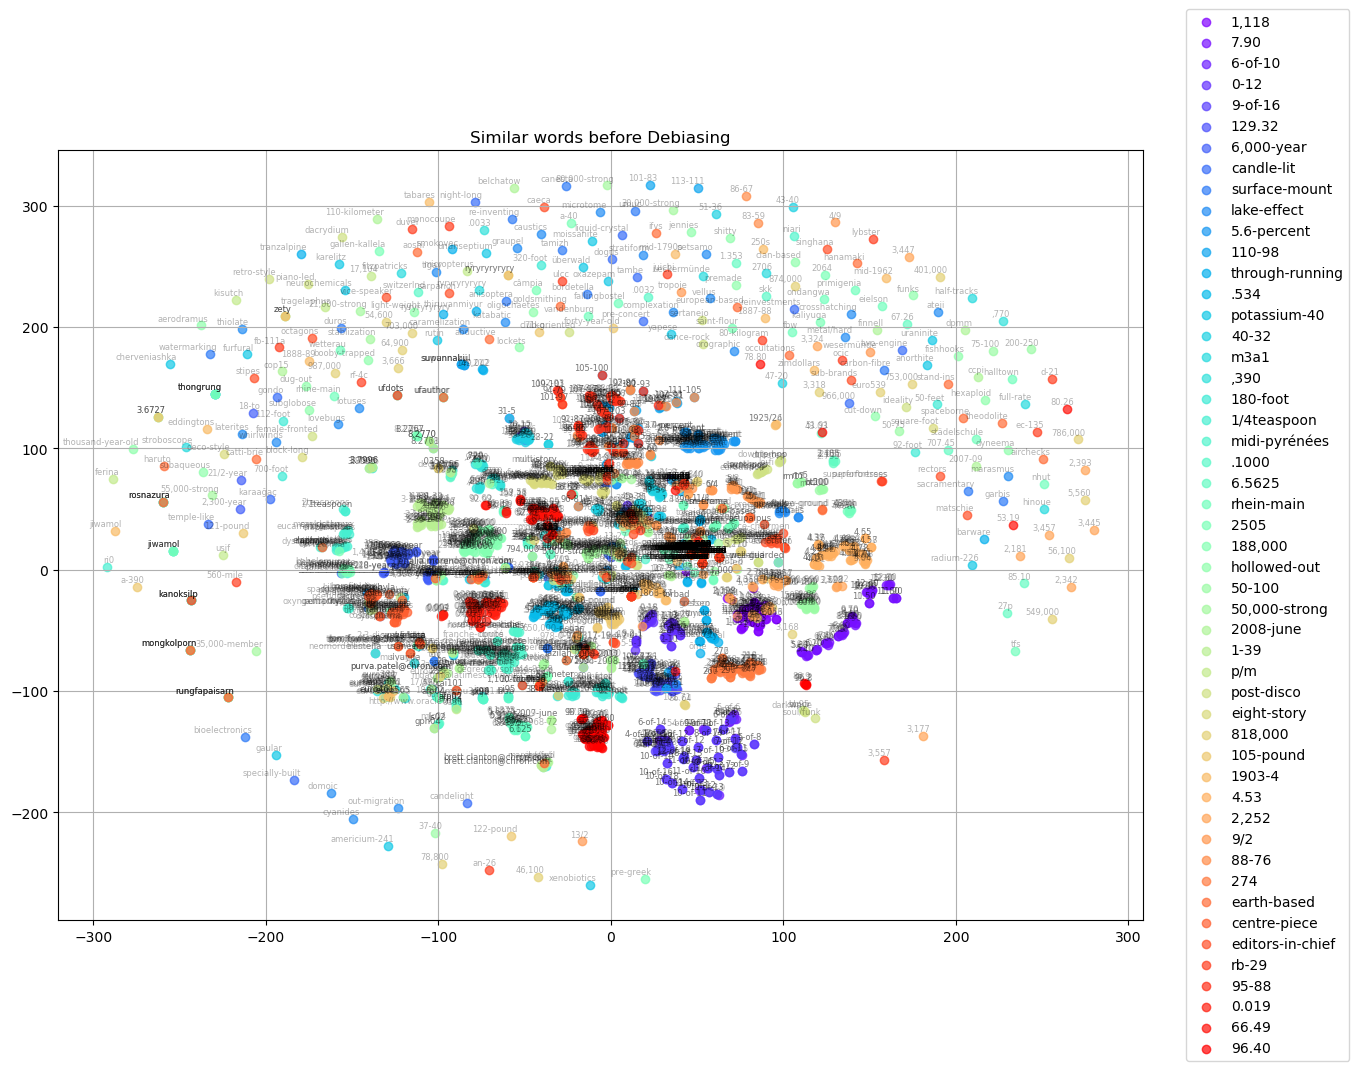

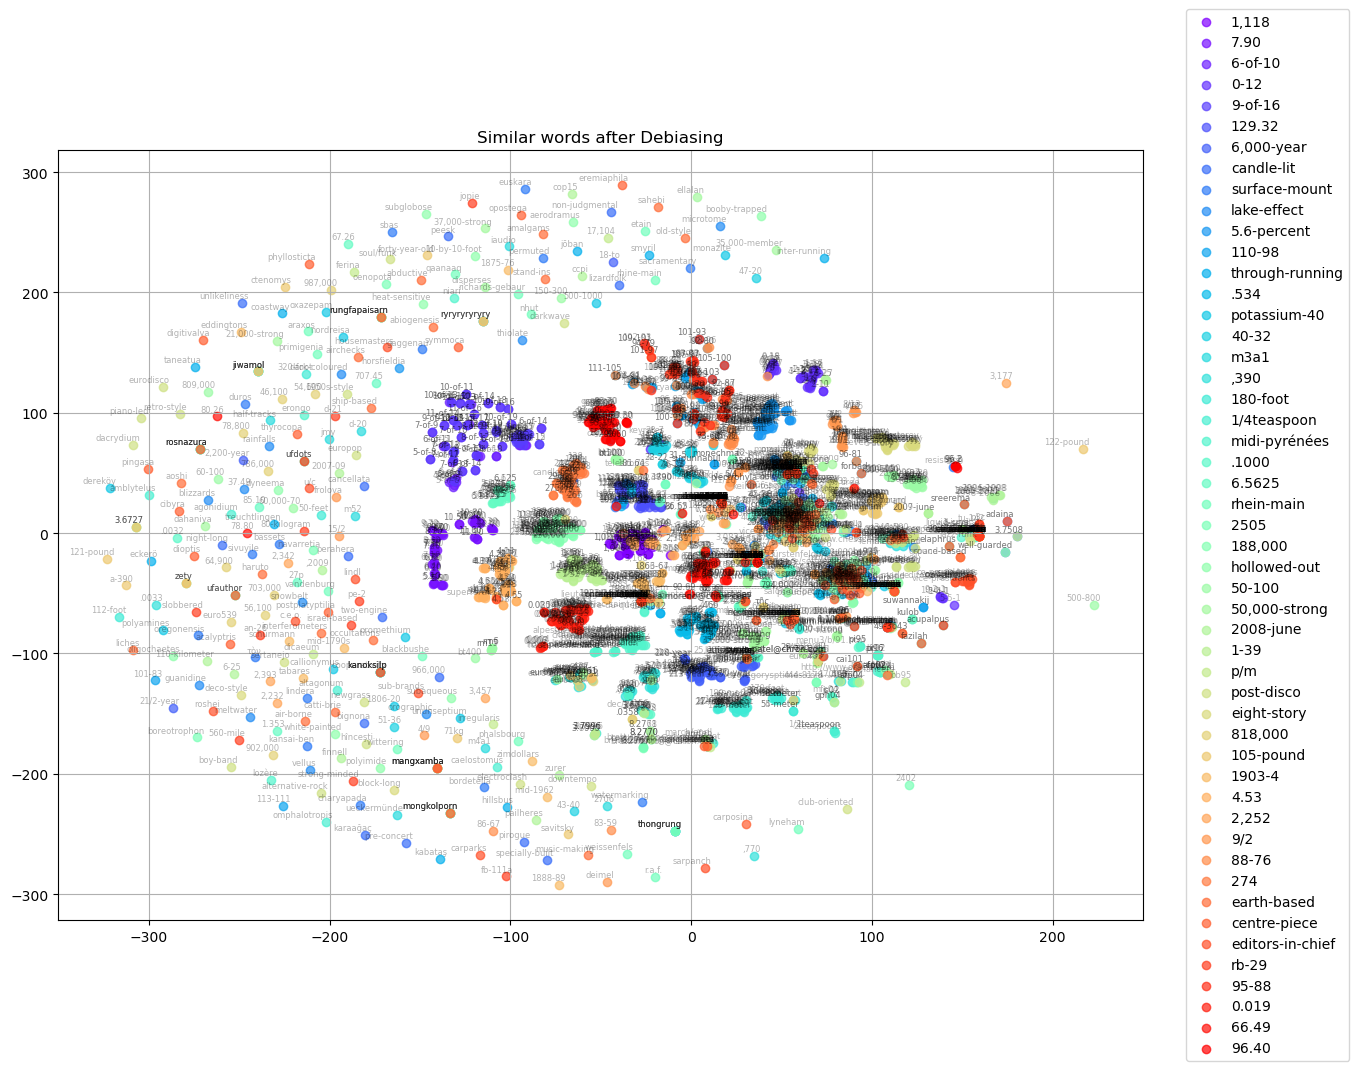

In [37]:
from Scripts.Visualization import tsne_plot_similar_words
from Scripts.Evaluation import get_vectors_for_tsne

#This approach was inspired by the following blog post:https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d

#Getting the Gensim models to plot the neighbors
model_debiased_punct = create_KeyedVectors(all_vectors, all_words, 300)

keys = list(df_punct['word'])
embeddings_en_2d, db_embeddings_en_2d, word_clusters = get_vectors_for_tsne(
    keys, glove.model, model_debiased_punct, k=50)

tsne_plot_similar_words('Similar words before Debiasing',
                        keys, embeddings_en_2d, word_clusters, 0.7)
tsne_plot_similar_words('Similar words after Debiasing',
                        keys, db_embeddings_en_2d, word_clusters, 0.7)


### Neutral words

In [38]:
gender_direction = identify_bias_subspace(
    dict_vectors, def_set_gender, 1, centralizing=True)

direct_gender_bias_original = compute_similarity_to_bias_direction(
    dict_vec_cleaned, gender_direction)



Length of vectors set: 22
Running PCA with 1 components


In [39]:
#transform the values of the direct_gender_bias_original dictionary to float
for word, value in direct_gender_bias_original.items():
    direct_gender_bias_original[word]=float(value)

In [40]:
orig_neutral = [word for word in direct_gender_bias_original.keys()
              if np.abs(direct_gender_bias_original[word])<0.001]

print('words closer to be neutral in original embeddings:',len(orig_neutral))
print('first 10 neutral words:', orig_neutral[:10])

words closer to be neutral in original embeddings: 2984
first 10 neutral words: ['my', 'population', 'california', 'products', 'angeles', 'killing', 'cents', 'details', 'museum', 'separate']


In [41]:
len(orig_neutral)


2984

In [42]:
df_nt = get_df_random_words_neighbor_analysis_values(
    orig_neutral, vocab_cleaned, dict_vec_cleaned, vectors_cleaned, word2idx_cleaned,
    deb_dict_gender, deb_vocab_gender, deb_vect_gender, deb_word2idx_gender,
    k=50, num_iterations=1, size_random_set=50)


100%|██████████| 50/50 [01:17<00:00,  1.55s/it]
50it [01:17,  1.55s/it]


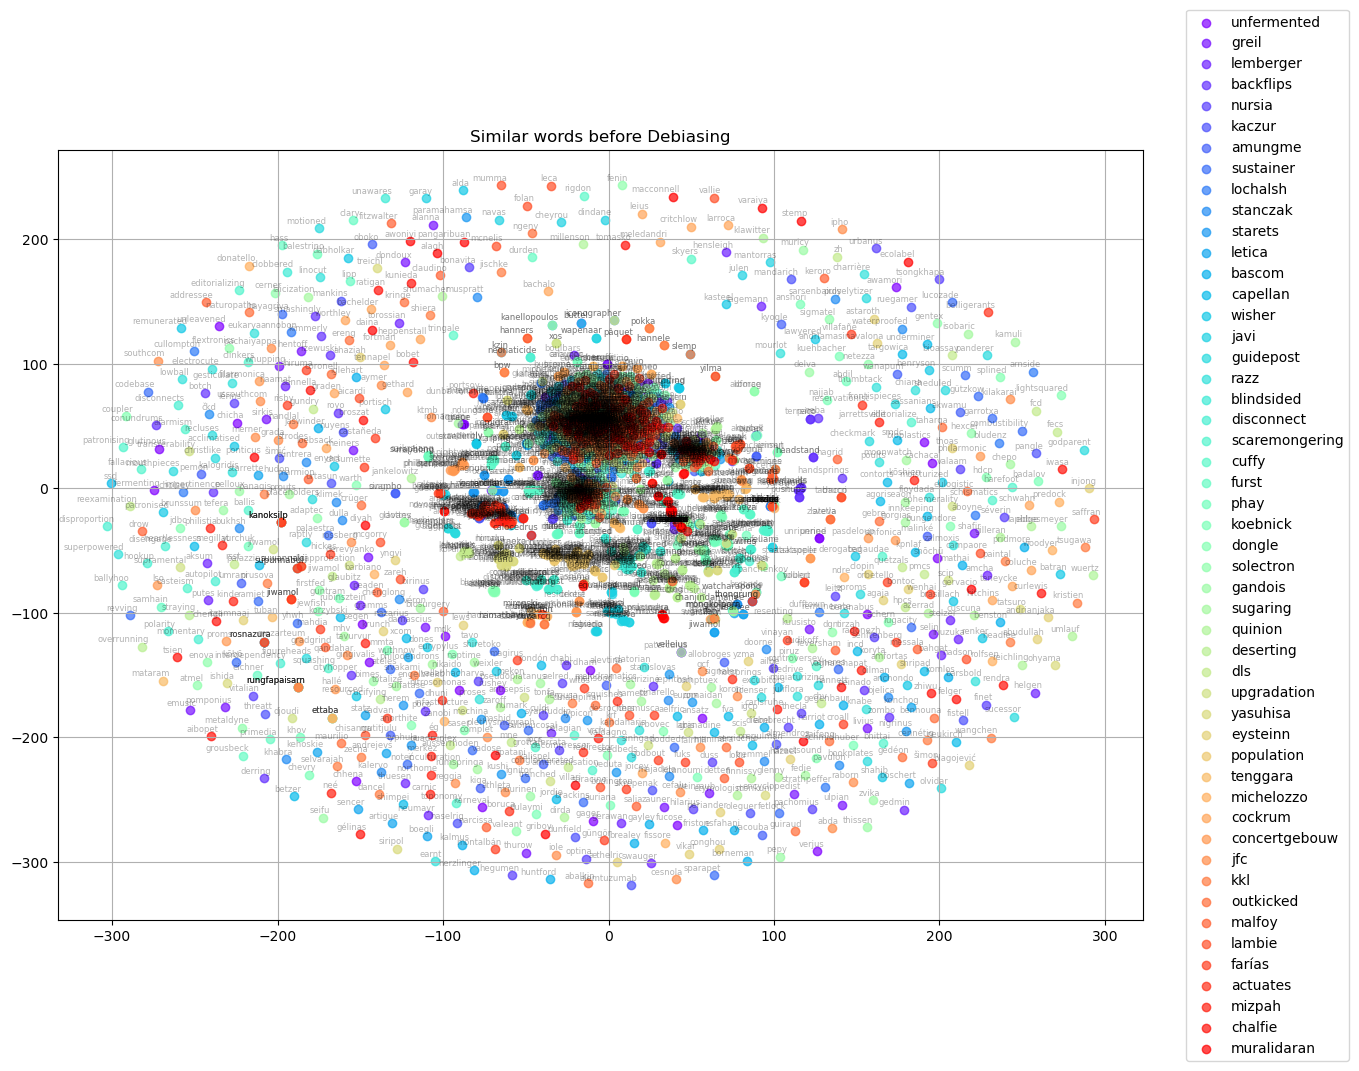

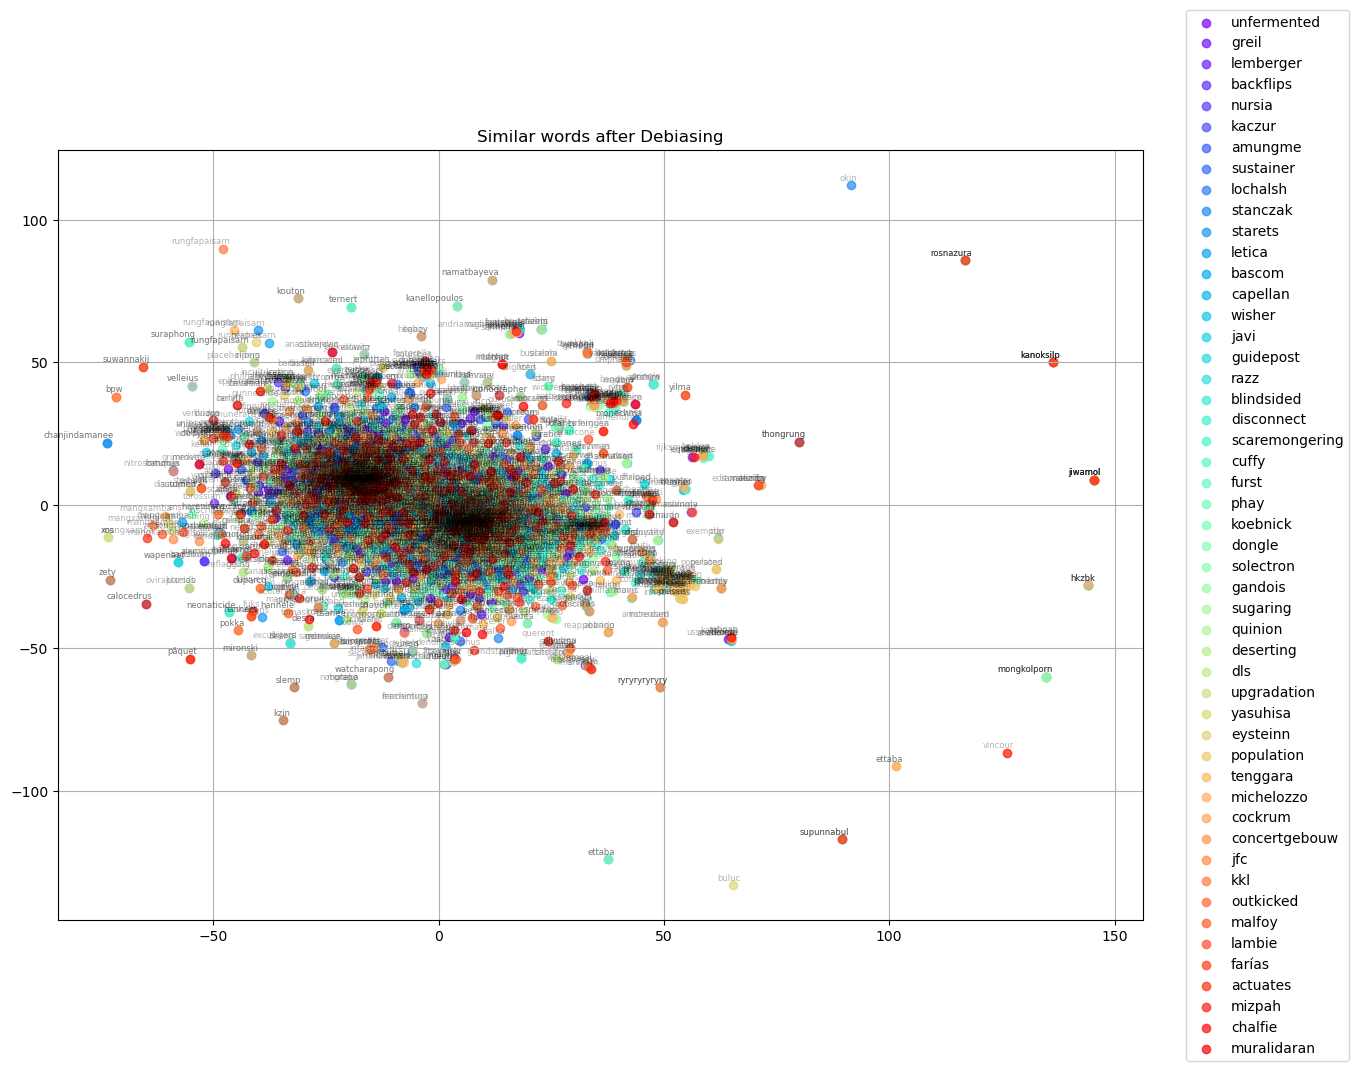

In [43]:
from Scripts.Visualization import tsne_plot_similar_words
from Scripts.Evaluation import get_vectors_for_tsne

#This approach was inspired by the following blog post:https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d

#Getting the Gensim models to plot the neighbors
model_original= create_KeyedVectors(vectors_cleaned, vocab_cleaned, 300)
model_debiased_gender=create_KeyedVectors(deb_vect_gender,deb_vocab_gender,300)

keys = list(df_nt['word'])
embeddings_en_2d, db_embeddings_en_2d, word_clusters = get_vectors_for_tsne(
    keys, model_original, model_debiased_gender, k=50)

tsne_plot_similar_words('Similar words before Debiasing',
                        keys, embeddings_en_2d, word_clusters, 0.7)
tsne_plot_similar_words('Similar words after Debiasing',
                        keys, db_embeddings_en_2d, word_clusters, 0.7)


In [180]:
plot_frequency_original_neighbors(df_nt[['word', 'freq']], "Frequencies of original neighbors to neutral words", 'words wih zero direct bias')

In [179]:
plot_average_distance(df_nt,
                      'Average distances from neighbors of neutral words', 'words wih zero direct bias')


In [44]:
#get a list with the first value of each tuple in the neighbors list
neighbors_words_nt = []
for random_word in k_neigh_neutral:
    for i in range(len(k_neigh_neutral[random_word])):
        neighbors_words_nt.append(k_neigh_neutral[random_word][i][0])


In [45]:
pval_nt = p_value_perm_neighs(random_neutral, neighbors_words_nt, dict_vec_cleaned,
                                 deb_dict_gender)


original mean: 0.023045335562509327
num of samples 250000


100%|██████████| 250000/250000 [1:52:27<00:00, 37.05it/s]  


In [49]:
pval_nt


0.495824

### Gendered words

In [47]:
orig_biased=[word for word in direct_gender_bias_original.keys() 
              if np.abs(direct_gender_bias_original[word])>0.25]

print('words closer to be biased in original embeddings:', len(orig_biased))
print('first 10 biased words:', orig_biased[:10])


words closer to be biased in original embeddings: 2444
first 10 biased words: ['he', 'his', 'she', 'her', 'women', 'john', 'man', 'george', 'chairman', 'himself']


In [48]:
df_bs = get_df_random_words_neighbor_analysis_values(
    orig_biased, vocab_cleaned, dict_vec_cleaned, vectors_cleaned, word2idx_cleaned,
    deb_dict_gender, deb_vocab_gender, deb_vect_gender, deb_word2idx_gender,
    k=50, num_iterations=1, size_random_set=50)


100%|██████████| 50/50 [01:19<00:00,  1.58s/it]
50it [01:18,  1.57s/it]


In [199]:
#remove duplicates from df_bs
df_bs = df_bs.drop_duplicates(subset=['word'])


/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from current font.

/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Matplotlib currently does not support Devanagari natively.

/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 2379 (\N{DEVANAGARI VOWEL SIGN O}) missing from current font.



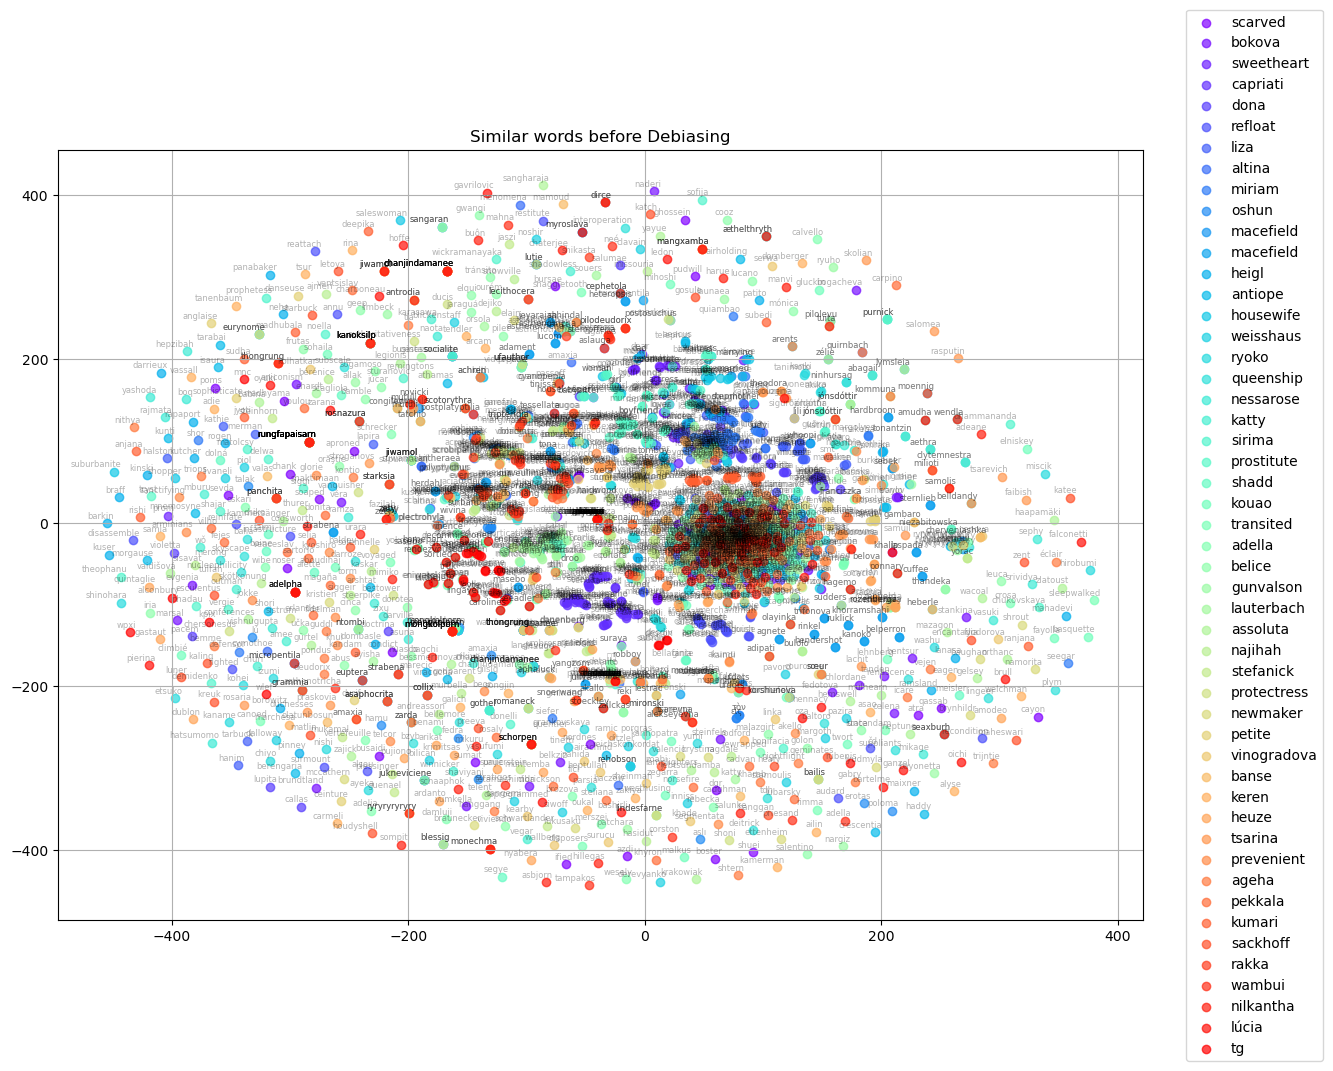

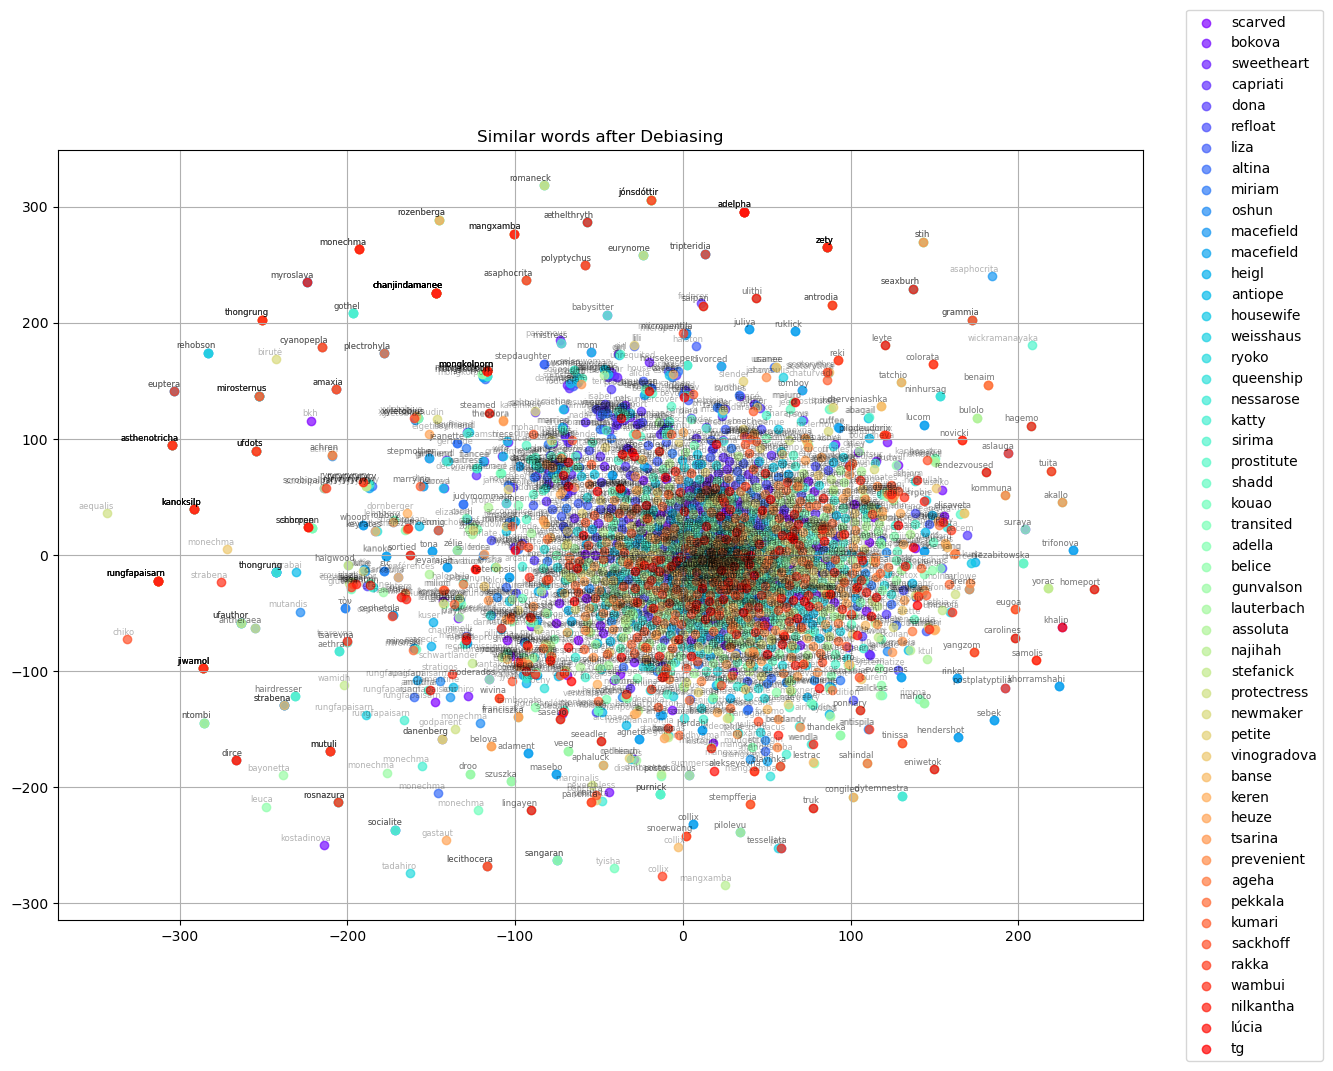

In [49]:
from Scripts.Visualization import tsne_plot_similar_words
from Scripts.Evaluation import get_vectors_for_tsne

#This approach was inspired by the following blog post:https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d

keys = list(df_bs['word'])
embeddings_en_2d, db_embeddings_en_2d, word_clusters = get_vectors_for_tsne(
    keys, model_original, model_debiased_gender, k=50)

tsne_plot_similar_words('Similar words before Debiasing',
                        keys, embeddings_en_2d, word_clusters, 0.7)
tsne_plot_similar_words('Similar words after Debiasing',
                        keys, db_embeddings_en_2d, word_clusters, 0.7)


In [200]:
plot_frequency_original_neighbors(
    df_bs[['word', 'freq']], "Frequencies of original neighbors to neutral words", 'words wih zero direct bias')


In [207]:
plot_average_distance(df_bs,
                      'Average distances from neighbors of neutral words', 'words wih zero direct bias')


### Occupations

In [52]:
#get the occupations that are in the vocab_cleaned
occupations_in_vocab = [word for word in occupations if word in vocab_cleaned]
print(len(occupations_in_vocab))


59


In [53]:
df_occ = get_df_random_words_neighbor_analysis_values(
    occupations_in_vocab, vocab_cleaned, dict_vec_cleaned, vectors_cleaned, word2idx_cleaned,
    deb_dict_gender, deb_vocab_gender, deb_vect_gender, deb_word2idx_gender,
    k=50, num_iterations=1, size_random_set=len(occupations_in_vocab))


100%|██████████| 59/59 [01:33<00:00,  1.58s/it]
59it [01:31,  1.55s/it]


In [127]:
plot_frequency_original_neighbors(
    df_occ[['word', 'freq']], "Frequencies of original neighbors to neutral words", 'words wih zero direct bias')


In [56]:
bias_neigh = bias_by_neighbors(simple_gender_bias_original, gender_bias_after_debiasing, occupations_in_vocab, deb_dict_gender, deb_vocab_gender,
                  deb_vect_gender, deb_word2idx_gender, neighbours_num=50)


100%|██████████| 59/59 [01:32<00:00,  1.57s/it]


In [57]:
#get a dataframe of the bias by neighbors (bias_neigh)
df_bias_neigh=pd.DataFrame(bias_neigh, columns=['word', 'bias_original', 'bias_debiased', 'f', 'm'])
df_bias_neigh['diff_neigh']=df_bias_neigh['f']-df_bias_neigh['m']




In [58]:
df_bias_neigh


word  bias_original  bias_debiased   f   m  diff_neigh
0      assistant      -0.065951      -0.027665  13  37         -24
1      secretary      -0.058412       0.013040   8  42         -34
2      scientist      -0.075615       0.029652  16  34         -18
3     politician      -0.092756      -0.009252  11  39         -28
4        janitor      -0.012418      -0.034179  29  21           8
5    hairdresser       0.156028      -0.012090  29  21           8
6        teacher       0.043036       0.033999  20  30         -10
7      bartender       0.045976      -0.022241  18  32         -14
8        midwife       0.211095      -0.009966  34  16          18
9         doctor       0.003835       0.013995  12  38         -26
10     ballerina       0.243311      -0.419075  34  16          18
11        dancer       0.156638       0.411772  29  21           8
12  pediatrician       0.115340       0.029326  27  23           4
13       surgeon      -0.045878       0.045211  16  34         -18
14     physician      -0.061494      -0.008957   9  41         -32
15    shopkeeper       0.000090      -0.005154  27  23           4
16         nurse       0.187380       0.028587  15  35         -20
17     architect      -0.103531      -0.030053  13  37         -24
18          maid       0.189010       0.437587  35  15          20
19   housekeeper       0.180631       0.007171  26  24           2
20       soprano       0.179808       0.416901  32  18          14
21      baritone      -0.029812      -0.394332  34  16          18
22       servant      -0.032303      -0.001536  17  33         -16
23     vocalists       0.125470      -0.011701  30  20          10
24    guitarists      -0.045485      -0.017798  30  20          10
25     carpenter      -0.017176       0.017039  18  32         -14
26         clerk       0.012428      -0.009814  24  26          -2
27       manager      -0.135291       0.032888  12  38         -26
28    supervisor       0.079018       0.047344  12  38         -26
29        driver      -0.089208      -0.014199   6  44         -38
30        lawyer      -0.038840       0.005068   8  42         -34
31       pitcher      -0.146017       0.016872  13  37         -24
32    bookkeeper       0.060888      -0.044456  28  22           6
33     infielder      -0.112174       0.024298  26  24           2
34  receptionist       0.169494      -0.056358  25  25           0
35  investigator      -0.015325       0.017255  22  28          -6
36        pundit      -0.016963       0.006606  22  28          -6
37    chancellor      -0.027802      -0.018355  15  35         -20
38       maestro      -0.067613      -0.015412  31  19          12
39      lecturer      -0.014610      -0.020184  17  33         -16
40   salesperson       0.053806      -0.039657  35  15          20
41     homemaker       0.204461       0.004034  20  30         -10
42  receptionist       0.169494      -0.056358  25  25           0
43     librarian       0.100899      -0.020090  23  27          -4
44         nanny       0.181539       0.007216  15  35         -20
45    bookkeeper       0.060888      -0.044456  28  22           6
46       stylist       0.179165      -0.014029  24  26          -2
47   housekeeper       0.180631       0.007171  26  24           2
48       skipper      -0.099069       0.020075  15  35         -20
49       protege      -0.033505      -0.038677  30  20          10
50   philosopher      -0.094847       0.011105  14  36         -22
51       captain      -0.109352       0.004064   7  43         -36
52     architect      -0.103531      -0.030053  13  37         -24
53     financier      -0.121391      -0.043628  24  26          -2
54       warrior       0.054117       0.061111  17  33         -16
55   broadcaster      -0.093981       0.042416  23  27          -4
56      magician      -0.047643       0.007665  23  27          -4
57         pilot      -0.042544       0.005960  13  37         -24
58          boss      -0.108633       0.000979  13  37     

In [187]:
#plot the bias by neighbors
#remove duplicates from df_bias_neigh
df_bias_neigh=df_bias_neigh.drop_duplicates(subset=['word'])
#plot results
fig1 = go.Figure()
# add a barplot with the f and m columns
fig1.add_trace(go.Bar(x=df_bias_neigh['word'],
                      y=df_bias_neigh['f'], name='Feminine Bias', 
                      marker_color='#a47c9b'))
fig1.add_trace(go.Bar(x=df_bias_neigh['word'],
                      y=df_bias_neigh['m'], name='Masculine Bias',
                      marker_color='#829e9a'))
#stack the bars
fig1.update_layout(barmode='stack')

#update the layout
fig1.update_layout(
    title='Bias by Neighbors',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Number of biased Neighbors',
        titlefont_size=16,
        tickfont_size=14,
    ),
    xaxis=dict(
        title='Occupations'
    ),
    #showlegend=False,
    plot_bgcolor='white',
    autosize=False,
    width=1200,
    height=500,
    margin=dict(
        
        b=200
    ),
    template='ggplot2'
)
fig1.show()



### Saving Embeddings on a txt file.
- And loading them as a Gensim model object

In [ ]:
#Saving the debiased vectors and vocab to a text file
glove.save_in_word2vec_format(
    debiased_vectors, debiased_vocab, "./Data/vecs.50.cleaned.txt")

#Loading the vectors into a KeyedVectors object 'model_cleaned' that we can use to find the most similar words to a given word
model_cleaned, _, _ = load_word_vectors(
    fname="./Data/vecs.50.cleaned.txt")



# Intersectional study
Bias is not binary nor one dimensional, if clusters are shuffled, what is the effect of the shuffling on other social classes? Is there a way to measure it?

In [79]:
#Find the words in the female_vocab that are also in the embeddings
female_words_emb = [
    word for word in female_vocab if word in dict_vec_cleaned.keys()]
male_words_emb = [
    word for word in male_vocab if word in dict_vec_cleaned.keys()]

print('Number of female words in embeddings:', len(female_words_emb))
print('Number of male words in embeddings:', len(male_words_emb))


Number of female words in embeddings: 182
Number of male words in embeddings: 183


In [81]:
#Lists of names for validation
#Adapted from Speer's tutorial on racism in sentiment analysis. http://blog.conceptnet.io/posts/2017/how-to-make-a-racist-ai-without-really-trying/
names_ethnicity = {
    # The first two lists are from the Caliskan et al. appendix describing the
    # Word Embedding Association Test.
    'White': [
        'Adam', 'Chip', 'Harry', 'Josh', 'Roger', 'Alan', 'Frank', 'Ian', 'Justin',
        'Ryan', 'Andrew', 'Fred', 'Jack', 'Matthew', 'Stephen', 'Brad', 'Greg', 'Jed',
        'Paul', 'Todd', 'Brandon', 'Hank', 'Jonathan', 'Peter', 'Wilbur', 'Amanda',
        'Courtney', 'Heather', 'Melanie', 'Sara', 'Amber', 'Crystal', 'Katie',
        'Meredith', 'Shannon', 'Betsy', 'Donna', 'Kristin', 'Nancy', 'Stephanie',
        'Bobbie-Sue', 'Ellen', 'Lauren', 'Peggy', 'Sue-Ellen', 'Colleen', 'Emily',
        'Megan', 'Rachel', 'Wendy'
    ],

    'Black': [
        'Alonzo', 'Jamel', 'Jamal', 'Lerone', 'Percell', 'Theo', 'Alphonse', 'Jerome',
        'Leroy', 'Rasaan', 'Torrance', 'Darnell', 'Lamar', 'Lionel', 'Rashaun',
        'Tyree', 'Deion', 'Lamont', 'Malik', 'Terrence', 'Tyrone', 'Everol',
        'Lavon', 'Marcellus', 'Terryl', 'Wardell', 'Aiesha', 'Lashelle', 'Nichelle',
        'Shereen', 'Temeka', 'Ebony', 'Latisha', 'Shaniqua', 'Tameisha', 'Teretha',
        'Jasmine', 'Latonya', 'Shanise', 'Tanisha', 'Tia', 'Lakisha', 'Latoya',
        'Sharise', 'Tashika', 'Yolanda', 'Lashandra', 'Malika', 'Shavonn',
        'Tawanda', 'Yvette'
    ],

    # This list comes from statistics about common Hispanic-origin names in the US.
    'Hispanic': [
        'Juan', 'José', 'Miguel', 'Luís', 'Jorge', 'Santiago', 'Matías', 'Sebastián',
        'Mateo', 'Nicolás', 'Alejandro', 'Samuel', 'Diego', 'Daniel', 'Tomás',
        'Juana', 'Ana', 'Luisa', 'María', 'Elena', 'Sofía', 'Isabella', 'Valentina',
        'Camila', 'Valeria', 'Ximena', 'Luciana', 'Mariana', 'Victoria', 'Martina'
    ],


}
#Following Bolukbasi et al. Implementing notebook: https://github.com/tolga-b/debiaswe/blob/master/tutorial_example1.ipynb
names = ["Emily", "Aisha", "Anne", "Keisha", "Jill", "Tamika", "Allison", "Lakisha", "Laurie", "Tanisha", "Sarah",
         "Latoya", "Meredith", "Kenya", "Carrie", "Latonya", "Kristen", "Ebony", "Todd", "Rasheed", "Neil", "Tremayne",
         "Geoffrey", "Kareem", "Brett", "Darnell", "Brendan", "Tyrone", "Greg", "Hakim", "Matthew", "Jamal", "Jay",
         "Leroy", "Brad", "Jermaine"]
#names_group1 = [names[2 * i] for i in range(len(names) // 2)]
#names_group2 = [names[2 * i + 1] for i in range(len(names) // 2)]


In [82]:
#Find the words in the female_vocab that are also in the embeddings
names_white_emb = [
    word.lower() for word in names_ethnicity['White'] if word.lower() in dict_vec_cleaned.keys()]
names_black_emb = [
    word.lower() for word in names_ethnicity['Black'] if word.lower() in dict_vec_cleaned.keys()]

names_hispanic_emb = [
    word.lower() for word in names_ethnicity['Hispanic'] if word.lower() in dict_vec_cleaned.keys()]


print('Number of white names in embeddings:', len(names_white_emb))
print('Number of black names in embeddings:', len(names_black_emb))
print('Number of hispanic names in embeddings:', len(names_hispanic_emb))


Number of white names in embeddings: 48
Number of black names in embeddings: 39
Number of hispanic names in embeddings: 30


In [83]:
#getting the gender directions
gen_dir_centralized=identify_bias_subspace(dict_vec_cleaned, def_set_gender, 1, centralizing=True)
#flattening them
gen_dir_centralized_flat=np.squeeze(gen_dir_centralized)

Length of vectors set: 22
Running PCA with 1 components


In [87]:
from Scripts.Evaluation import compute_gender_simple_bias, compute_similarity_to_bias_direction
similarity_centralized=compute_similarity_to_bias_direction(dict_vec_cleaned, gen_dir_centralized_flat)
simple_gender_bias=compute_gender_simple_bias(dict_vec_cleaned, dict_vec_cleaned['he'], dict_vec_cleaned['she'])
deb_similarity_centralized=compute_similarity_to_bias_direction(deb_dict_gender, gen_dir_centralized_flat)
deb_simple_gender_bias=compute_gender_simple_bias(deb_dict_gender, deb_dict_gender['he'], deb_dict_gender['she'])

In [90]:
df_names_white = utils.get_df_bias_scores(
    names_white_emb, similarity_centralized, simple_gender_bias)
df_names_black = utils.get_df_bias_scores(
    names_black_emb, similarity_centralized, simple_gender_bias)
df_names_hispanic = utils.get_df_bias_scores(
    names_hispanic_emb, similarity_centralized, simple_gender_bias)

#now the dataframe for the debiased embeddings
df_names_white_deb = utils.get_df_bias_scores(
    names_white_emb, deb_similarity_centralized, deb_simple_gender_bias)
df_names_black_deb = utils.get_df_bias_scores(
    names_black_emb, deb_similarity_centralized, deb_simple_gender_bias)
df_names_hispanic_deb = utils.get_df_bias_scores(
    names_hispanic_emb, deb_similarity_centralized, deb_simple_gender_bias)

#merging the dataframes
df_names_white_merged = pd.merge(df_names_white, df_names_white_deb,
                                 left_index=True, right_index=True, suffixes=('_orig', '_deb'))
df_names_black_merged = pd.merge(df_names_black, df_names_black_deb,
                                 left_index=True, right_index=True, suffixes=('_orig', '_deb'))
df_names_hispanic_merged = pd.merge(
    df_names_hispanic, df_names_hispanic_deb, left_index=True, right_index=True, suffixes=('_orig', '_deb'))


df_names_white_merged


centralized_similarity_score_orig  simple_bias_score_orig  \
adam                               -0.197002               -0.094373   
chip                               -0.049744               -0.020428   
harry                              -0.088865                0.006493   
josh                               -0.102430               -0.014186   
roger                              -0.243526               -0.110803   
alan                               -0.137599               -0.048589   
frank                              -0.189593               -0.068455   
ian                                -0.142574               -0.049633   
justin                             -0.130470               -0.019525   
ryan                               -0.088061               -0.017689   
andrew                             -0.199507               -0.096075   
fred                               -0.135545               -0.041800   
jack                               -0.138957               -0.035740   
matthew                            -0.118881               -0.020964   
stephen                            -0.220796               -0.100459   
brad                               -0.132319               -0.053200   
greg                               -0.199286               -0.074344   
jed                                -0.041501               -0.021692   
paul                               -0.240546               -0.113225   
todd                               -0.068165                0.017310   
brandon                            -0.078822               -0.022180   
hank                               -0.099746               -0.035888   
jonathan                           -0.137815               -0.042783   
peter                              -0.230704               -0.090993   
wilbur                              0.022579                0.063743   
amanda                              0.271990                0.250297   
courtney                            0.081068                0.102521   
heather                             0.219969                0.193770   
melanie                             0.282223                0.254718   
sara                                0.257723                0.187402   
amber                               0.179529                0.113414   
crystal                             0.026972                0.022183   
katie                               0.255942                0.259524   
meredith                            0.113222                0.100545   
shannon                             0.066973                0.070266   
betsy                               0.214281                0.168720   
donna                               0.246542                0.204152   
kristin                             0.204476                0.169462   
nancy                               0.218335                0.203215   
stephanie                           0.289505                0.282828   
ellen                               0.319631                0.240541   
lauren                              0.178659                0.212271   
peggy                               0.225862                0.199953   
colleen                             0.172724                0.168880   
emily                               0.280629                0.241137   
megan                               0.258755                0.235742   
rachel                              0.291106                0.259042   
wendy                               0.182157                0.191772   

           centralized_similarity_score_deb  simple_bias_score_deb  
adam                              -0.005653           1.493309e-09  
chip                              -0.005121           5.179480e-09  
harry                             -0.016171           3.913110e-09  
josh                              -0.008215           6.410092e-09  
roger                             -0.011060           7.128524e-09  
alan                              -0.012589           5.221612e-09  

In [91]:
from Scripts.Visualization import plot_top_biased_words

plot_top_biased_words(df_names_white, n_words=50)
plot_top_biased_words(df_names_black, n_words=50)
plot_top_biased_words(df_names_hispanic, n_words=50)


In [92]:
from Scripts.Evaluation import *


Let's first define the sets to be used at weat:

In [93]:
career = ['executive', 'management', 'professional',
          'corporation', 'salary', 'office', 'business', 'career']
family = ['home', 'parents', 'children', 'family',
          'cousins', 'marriage', 'wedding', 'relatives']


low_wage_occupations = ['operator', 'laborer', 'cleaner', 'guard',
                        'plumber', 'janitor', 'fireman', 'waiter',
                        'maid', 'cook', 'clerk', 'assistant', 'mechanic',
                        'porter', 'electrician', 'carpenter', 'tailor',
                        'hairdresser', 'helper']


pleasant = ["caress", "freedom", "health", "love", "peace", "cheer",
            "friend", "heaven", "loyal", "pleasure", "diamond", "gentle",
            "honest", "lucky", "rainbow", "diploma", "gift", "honor",
            "miracle", "sunrise", "family", "happy", "laughter", "paradise", "vacation"]

unpleasant = ["abuse", "crash", "filth", "murder", "sickness", "accident", "death",
              "grief", "poison", "stink", "assault", "disaster",
              "hatred", "pollute", "tragedy", "bomb", "divorce", "jail",
              "poverty", "ugly", "cancer", "evil", "kill", "rotten", "vomit"]

music = ["bagpipe", "cello", "guitar", "lute", "trombone", "banjo", "clarinet", "harmonica",
         "mandolin", "trumpet", "bassoon", "drum", "harp", "oboe", "tuba", "bell", "fiddle",
         "harpsichord", "piano", "viola", "bongo", "flute", "horn", "saxophone", "violin", "voice"]
guns = ["arrow", "club", "gun", "missile", "spear", "axe", "dagger", "harpoon", "pistol", "sword",
        "blade", "dynamite", "hatchet", "rifle", "tank", "bomb", "firearm", "knife", "shotgun",
        "teargas", "cannon", "grenade", "mace", "slingshot", "whip"]


In [94]:
male_black_names = names_black_emb[:10]
male_white_names = names_white_emb[:10]
female_black_names = names_black_emb[-10:]
female_white_names = names_white_emb[-10:]
female_hispanic_names = names_hispanic_emb[-10:]
male_hispanic_names = names_hispanic_emb[:10]


#printing the above lists of names
print("Male names; black ethnicity:", male_black_names)
print("Female names; black ethnicity:", female_black_names)
print("Male names; hispanic ethnicity:", male_hispanic_names)
print("Female names; hispanic ethnicity:", female_hispanic_names)
print("Male names; white ethnicity:", male_white_names)
print("Female names; white ethnicity:", female_white_names)


Male names; black ethnicity: ['alonzo', 'jamel', 'jamal', 'lerone', 'theo', 'alphonse', 'jerome', 'leroy', 'torrance', 'darnell']
Female names; black ethnicity: ['jasmine', 'latonya', 'tanisha', 'tia', 'lakisha', 'latoya', 'yolanda', 'malika', 'tawanda', 'yvette']
Male names; hispanic ethnicity: ['juan', 'josé', 'miguel', 'luís', 'jorge', 'santiago', 'matías', 'sebastián', 'mateo', 'nicolás']
Female names; hispanic ethnicity: ['sofía', 'isabella', 'valentina', 'camila', 'valeria', 'ximena', 'luciana', 'mariana', 'victoria', 'martina']
Male names; white ethnicity: ['adam', 'chip', 'harry', 'josh', 'roger', 'alan', 'frank', 'ian', 'justin', 'ryan']
Female names; white ethnicity: ['nancy', 'stephanie', 'ellen', 'lauren', 'peggy', 'colleen', 'emily', 'megan', 'rachel', 'wendy']


All male and female

In [95]:
# Experiment 1:
# Pleasant and unpleasant words
print('Female and male names with guns and music words')
print('Before Debiasing')
print(p_value_sample_weat(dict_vec_cleaned,male_black_names+male_white_names+male_hispanic_names, female_white_names+female_black_names+female_hispanic_names, guns, music))
print('After Debiasing')
print(p_value_sample_weat(deb_dict_gender,male_black_names+male_white_names+male_hispanic_names, female_white_names+female_black_names+female_hispanic_names, guns, music))

Female and male names with guns and music words
Before Debiasing
num of samples 1000000
0.838351
After Debiasing
num of samples 1000000
0.00973


In [96]:
# Experiment 2:
# Pleasant and unpleasant words
print('Female and male names with pleasant and unpleasant words')
print('Before Debiasing')
print(p_value_sample_weat(dict_vec_cleaned,male_black_names+male_white_names+male_hispanic_names, female_white_names+female_black_names+female_hispanic_names, pleasant, unpleasant))
print('After Debiasing')
print(p_value_sample_weat(deb_dict_gender,male_black_names+male_white_names+male_hispanic_names, female_white_names+female_black_names+female_hispanic_names, pleasant, unpleasant))

Female and male names with pleasant and unpleasant words
Before Debiasing
num of samples 1000000
0.076277
After Debiasing
num of samples 1000000
0.880367


In [97]:
# Experiment 3:
# career and family words
print('Female and male names with career and family words')
print('Before Debiasing')
print(p_value_sample_weat(dict_vec_cleaned,male_black_names+male_white_names+male_hispanic_names, female_white_names+female_black_names+female_hispanic_names, career, family))
print('After Debiasing')
print(p_value_sample_weat(deb_dict_gender,male_black_names+male_white_names+male_hispanic_names, female_white_names+female_black_names+female_hispanic_names, career, family))

Female and male names with career and family words
Before Debiasing
num of samples 1000000
0.0
After Debiasing
num of samples 1000000
0.171387


In [98]:
# Experiment 4:
# career and low_wage_occupations words
print('Female and male names with career and low wage words')
print('Before Debiasing')
print(p_value_sample_weat(dict_vec_cleaned,male_black_names+male_white_names+male_hispanic_names, female_white_names+female_black_names+female_hispanic_names, career, low_wage_occupations))
print('After Debiasing')
print(p_value_sample_weat(deb_dict_gender,male_black_names+male_white_names+male_hispanic_names, female_white_names+female_black_names+female_hispanic_names, career, low_wage_occupations))

Female and male names with career and low wage words
Before Debiasing
num of samples 1000000
4.5e-05
After Debiasing
num of samples 1000000
0.009467


Only African-American names and European-American Names

In [99]:
# Experiment 1:
# Pleasant and unpleasant words
print('Female and male names with guns and music words')
print('Before Debiasing')
print(p_value_sample_weat(dict_vec_cleaned, male_black_names+male_white_names,
      female_white_names+female_black_names, guns, music))
print('After Debiasing')
print(p_value_sample_weat(deb_dict_gender, male_black_names+male_white_names,
      female_white_names+female_black_names, guns, music))


print('_________________________________________________________')
# Experiment 2:
# Pleasant and unpleasant words
print('Female and male names with pleasant and unpleasant words')
print('Before Debiasing')
print(p_value_sample_weat(dict_vec_cleaned, male_black_names+male_white_names,
      female_white_names+female_black_names, pleasant, unpleasant))
print('After Debiasing')
print(p_value_sample_weat(deb_dict_gender, male_black_names+male_white_names,
      female_white_names+female_black_names, pleasant, unpleasant))


print('_________________________________________________________')
# Experiment 3:
# career and family words
print('Female and male names with career and family words')
print('Before Debiasing')
print(p_value_sample_weat(dict_vec_cleaned, male_black_names+male_white_names,
      female_white_names+female_black_names, career, family))
print('After Debiasing')
print(p_value_sample_weat(deb_dict_gender, male_black_names+male_white_names,
      female_white_names+female_black_names, career, family))

print('_________________________________________________________')
# Experiment 4:
# career and low_wage_occupations words
print('Female and male names with career and low wage words')
print('Before Debiasing')
print(p_value_sample_weat(dict_vec_cleaned, male_black_names+male_white_names,
                     female_white_names+female_black_names, career, low_wage_occupations))
print('After Debiasing')
print(p_value_sample_weat(deb_dict_gender, male_black_names+male_white_names,
                     female_white_names+female_black_names, career, low_wage_occupations))


Female and male names with guns and music words
Before Debiasing
num of samples 1000000
0.359863
After Debiasing
num of samples 1000000
0.019912
_________________________________________________________
Female and male names with pleasant and unpleasant words
Before Debiasing
num of samples 1000000
0.220284
After Debiasing
num of samples 1000000
0.814952
_________________________________________________________
Female and male names with career and family words
Before Debiasing
num of samples 1000000
1e-06
After Debiasing
num of samples 1000000
0.163114
_________________________________________________________
Female and male names with career and low wage words
Before Debiasing
num of samples 1000000
0.000788
After Debiasing
num of samples 1000000
0.01632


### Intersections

In [100]:
#Black and white names with career and family
print('Black and white male names with career and family')
print('Before Debiasing')
print(p_value_exhust_weat(dict_vec_cleaned, male_white_names,
      male_black_names, career, family))
print('After Debiasing')
print(p_value_exhust_weat(deb_dict_gender, male_white_names,
      male_black_names, career, family))
print('----------------------------------------------------')

#Black and white names with career and low wage occupations
print('Black and white male names with career and low_wage_occupations')
print('Before Debiasing')
print(p_value_exhust_weat(dict_vec_cleaned, male_white_names,
      male_black_names, career, low_wage_occupations))
print('After Debiasing')
print(p_value_exhust_weat(deb_dict_gender, male_white_names,
      male_black_names, career, low_wage_occupations))
print('----------------------------------------------------')
#Black and white names with pleasant and unpleasant words
print('Black and white male names with pleasant and unpleasant words')
print('Before Debiasing')
print(p_value_exhust_weat(dict_vec_cleaned, male_white_names,
      male_black_names, pleasant, unpleasant))
print('After Debiasing')
print(p_value_exhust_weat(deb_dict_gender, male_white_names,
      male_black_names, pleasant, unpleasant))

print('----------------------------------------------------')

#Black and white names with music and guns
print('Black and white male names with music and guns')
print('Before Debiasing')
print(p_value_exhust_weat(dict_vec_cleaned,
      male_white_names, male_black_names, guns, music))
print('After Debiasing')
print(p_value_exhust_weat(deb_dict_gender,
      male_white_names, male_black_names, guns, music))


Black and white male names with career and family
Before Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 200990.59it/s]


num of samples 184756
0.1992357487713525
After Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 201491.87it/s]


num of samples 184756
0.3410335794236723
----------------------------------------------------
Black and white male names with career and low_wage_occupations
Before Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 205219.89it/s]


num of samples 184756
0.0
After Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 201533.64it/s]


num of samples 184756
0.0021758427331182747
----------------------------------------------------
Black and white male names with pleasant and unpleasant words
Before Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 201715.67it/s]


num of samples 184756
0.0008281192491718807
After Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 206081.75it/s]


num of samples 184756
0.11043755006603304
----------------------------------------------------
Black and white male names with music and guns
Before Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 197627.28it/s]


num of samples 184756
0.16658187014224166
After Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 201039.76it/s]

num of samples 184756
0.0028740609235965273


In [101]:
#Black and white female names with career and family
print('Black and white female names with career and family')
print('Before Debiasing')
print(p_value_exhust_weat(dict_vec_cleaned, female_white_names,
      female_black_names, career, family))
print('After Debiasing')
print(p_value_exhust_weat(deb_dict_gender, female_white_names,
      female_black_names, career, family))
print('----------------------------------------------------')

#Black and white female names with career and low wage occupations
print('Black and white female names with career and low_wage_occupations')
print('Before Debiasing')
print(p_value_exhust_weat(dict_vec_cleaned, female_white_names,
      female_black_names, career, low_wage_occupations))
print('After Debiasing')
print(p_value_exhust_weat(deb_dict_gender, female_white_names,
      female_black_names, career, low_wage_occupations))
print('----------------------------------------------------')
#Black and white female names with pleasant and unpleasant words
print('Black and white female names with pleasant and unpleasant words')
print('Before Debiasing')
print(p_value_exhust_weat(dict_vec_cleaned, female_white_names,
      female_black_names, pleasant, unpleasant))
print('After Debiasing')
print(p_value_exhust_weat(deb_dict_gender, female_white_names,
      female_black_names, pleasant, unpleasant))

print('----------------------------------------------------')

#Black and white female names with music and guns
print('Black and white female names with music and guns')
print('Before Debiasing')
print(p_value_exhust_weat(dict_vec_cleaned,
      female_white_names, female_black_names, guns, music))
print('After Debiasing')
print(p_value_exhust_weat(deb_dict_gender, female_white_names,
      female_black_names, guns, music))


Black and white female names with career and family
Before Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 203798.29it/s]


num of samples 184756
0.8410931174089069
After Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 204153.67it/s]


num of samples 184756
0.010467860313061551
----------------------------------------------------
Black and white female names with career and low_wage_occupations
Before Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 208934.06it/s]


num of samples 184756
3.247526467340709e-05
After Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 202686.88it/s]


num of samples 184756
3.78878087856416e-05
----------------------------------------------------
Black and white female names with pleasant and unpleasant words
Before Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 203159.86it/s]


num of samples 184756
0.0012069973370282968
After Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 209627.89it/s]


num of samples 184756
0.16180800623525082
----------------------------------------------------
Black and white female names with music and guns
Before Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 206767.17it/s]


num of samples 184756
0.025628396371430426
After Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 206570.62it/s]


num of samples 184756
0.014023901794799627


In [102]:
#Black male and white female names with career and family
print('Black male and white female names with career and family')
print('Before Debiasing')
print(p_value_exhust_weat(dict_vec_cleaned, male_black_names,
      female_white_names, career, family))
print('After Debiasing')
print(p_value_exhust_weat(deb_dict_gender, male_black_names,
      female_white_names, career, family))
print('----------------------------------------------------')

#Black and white female names with career and low wage occupations
print('Black male and white female names with career and low_wage_occupations')
print('Before Debiasing')
print(p_value_exhust_weat(dict_vec_cleaned, male_black_names,
      female_white_names, career, low_wage_occupations))
print('After Debiasing')
print(p_value_exhust_weat(deb_dict_gender, male_black_names,
      female_white_names, career, low_wage_occupations))
print('----------------------------------------------------')
#Black and white female names with pleasant and unpleasant words
print('Black male and white female names with pleasant and unpleasant words')
print('Before Debiasing')
print(p_value_exhust_weat(dict_vec_cleaned, male_black_names,
      female_white_names, pleasant, unpleasant))
print('After Debiasing')
print(p_value_exhust_weat(deb_dict_gender, male_black_names,
      female_white_names, pleasant, unpleasant))

print('----------------------------------------------------')

#Black and white female names with music and guns
print('Black male and white female names with music and guns')
print('Before Debiasing')
print(p_value_exhust_weat(dict_vec_cleaned,
      male_black_names, female_white_names, guns, music))
print('After Debiasing')
print(p_value_exhust_weat(deb_dict_gender,
      male_black_names, female_white_names, guns, music))


Black male and white female names with career and family
Before Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 210385.79it/s]


num of samples 184756
0.0001840264998159735
After Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 208491.04it/s]


num of samples 184756
0.742243824287168
----------------------------------------------------
Black male and white female names with career and low_wage_occupations
Before Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 210989.32it/s]


num of samples 184756
0.8988990885275715
After Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 208975.36it/s]


num of samples 184756
0.9679144385026738
----------------------------------------------------
Black male and white female names with pleasant and unpleasant words
Before Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 211225.97it/s]


num of samples 184756
0.9937106237415835
After Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 209317.09it/s]


num of samples 184756
0.9479746259932018
----------------------------------------------------
Black male and white female names with music and guns
Before Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 207833.45it/s]


num of samples 184756
0.9126307129403105
After Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 209142.86it/s]

num of samples 184756
0.835994500855182


In [103]:
#Black female and white male names with career and family
print('Black female and white male names with career and family')
print('Before Debiasing')
print(p_value_exhust_weat(dict_vec_cleaned, male_white_names,
      female_black_names, career, family))
print('After Debiasing')
print(p_value_exhust_weat(deb_dict_gender, male_white_names,
      female_black_names, career, family))
print('----------------------------------------------------')

#Black and white female names with career and low wage occupations
print('Black female and white male names with career and low_wage_occupations')
print('Before Debiasing')
print(p_value_exhust_weat(dict_vec_cleaned, male_white_names,
      female_black_names, career, low_wage_occupations))
print('After Debiasing')
print(p_value_exhust_weat(deb_dict_gender, male_white_names,
      female_black_names, career, low_wage_occupations))
print('----------------------------------------------------')
#Black and white female names with pleasant and unpleasant words
print('Black female and white male names with pleasant and unpleasant words')
print('Before Debiasing')
print(p_value_exhust_weat(dict_vec_cleaned, male_white_names,
      female_black_names, pleasant, unpleasant))
print('After Debiasing')
print(p_value_exhust_weat(deb_dict_gender, male_white_names,
      female_black_names, pleasant, unpleasant))

print('----------------------------------------------------')

#Black and white female names with music and guns
print('Black female and white male names with music and guns')
print('Before Debiasing')
print(p_value_exhust_weat(dict_vec_cleaned,
      male_white_names, female_black_names, guns, music))
print('After Debiasing')
print(p_value_exhust_weat(deb_dict_gender,
      male_white_names, female_black_names, guns, music))

Black female and white male names with career and family
Before Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 202278.81it/s]


num of samples 184756
0.0009634328519777436
After Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 203329.54it/s]


num of samples 184756
0.02463790079889151
----------------------------------------------------
Black female and white male names with career and low_wage_occupations
Before Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 208388.27it/s]


num of samples 184756
0.0
After Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 203108.96it/s]


num of samples 184756
5.412544112234515e-06
----------------------------------------------------
Black female and white male names with pleasant and unpleasant words
Before Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 207568.13it/s]


num of samples 184756
5.412544112234515e-05
After Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 206759.83it/s]


num of samples 184756
0.3161142263309446
----------------------------------------------------
Black female and white male names with music and guns
Before Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 204399.38it/s]


num of samples 184756
0.05074260105219858
After Debiasing


100%|██████████| 184756/184756 [00:00<00:00, 203923.63it/s]

num of samples 184756
0.00012448851458139384
